In [7]:
# from circuit_suite import circuits
# # from backend_suite import backends, large_backends, shuffle_test, routing_test
# #from backend_suite import placement_test


In [13]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Reduce 1Q gate complexity by commuting through 2Q gates and resynthesizing."""

from copy import copy
import logging

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.standard_gates import CXGate, RZXGate
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passes.optimization.optimize_1q_decomposition import (
    Optimize1qGatesDecomposition,
)

logger = logging.getLogger(__name__)


commutation_table = {
    RZXGate: (["rz", "p"], ["x", "sx", "rx"]),
    CXGate: (["rz", "p"], ["x", "sx", "rx"]),
}
"""
Simple commutation rules: G belongs to commutation_table[barrier_type][qubit_preindex] when G
commutes with the indicated barrier on that qubit wire.

NOTE: Does not cover identities like
          (X (x) I) .   CX = CX .   (X (x) X) ,  (duplication)
          (U (x) I) . SWAP = SWAP . (I (x) U) .  (permutation)

NOTE: These rules are _symmetric_, so that they may be applied in reverse.
"""


class Optimize1qGatesSimpleCommutation(TransformationPass):
    """
    Optimizes 1Q gate strings interrupted by 2Q gates by commuting the components and re-
    synthesizing the results.  The commutation rules are stored in `commutation_table`.

    NOTE: In addition to those mentioned in `commutation_table`, this pass has some limitations:
          + Does not handle multiple commutations in a row without intermediate progress.
          + Can only commute into positions where there are pre-existing runs.
          + Does not exhaustively test all the different ways commuting gates can be assigned to
            either side of a barrier to try to find low-depth configurations.  (This is particularly
            evident if all the gates in a run commute with both the predecessor and the successor
            barriers.)
    """

    # NOTE: A run from `dag.collect_1q_runs` is always nonempty, so we sometimes use an empty list
    #       to signify the absence of a run.

    def __init__(self, basis=None, run_to_completion=False):
        """
        Args:
            basis (List[str]): See also `Optimize1qGatesDecomposition`.
            run_to_completion (bool): If `True`, this pass retries until it is unable to do any more
                work.  If `False`, it finds and performs one optimization, and for full optimization
                the user is obligated to re-call the pass until the output stabilizes.
        """
        super().__init__()

        self._basis = basis
        self._optimize1q = Optimize1qGatesDecomposition(basis)
        self._run_to_completion = run_to_completion

    @staticmethod
    def _find_adjoining_run(dag, runs, run, front=True):
        """
        Finds the run which abuts `run` from the front (or the rear if `front == False`), separated
        by a blocking node.

        Returns a pair of the abutting multi-qubit gate and the run which it separates from this
        one. The next run can be the empty list `[]` if it is absent.
        """
        edge_node = run[0] if front else run[-1]
        blocker = next(
            dag.predecessors(edge_node) if front else dag.successors(edge_node)
        )
        possibilities = dag.predecessors(blocker) if front else dag.successors(blocker)

        adjoining_run = []
        for possibility in possibilities:
            if (
                isinstance(possibility, DAGOpNode)
                and possibility.qargs == edge_node.qargs
            ):
                adjoining_run = next((run for run in runs if possibility in run), [])
                break

        return (blocker, adjoining_run)

    @staticmethod
    def _commute_through(blocker, run, front=True):
        """
        Pulls `DAGOpNode`s from the front of `run` (or the back, if `front == False`) until it
        encounters a gate which does not commute with `blocker`.

        Returns a pair of lists whose concatenation is `run`.
        """

        if run == []:
            return [], []

        run_clone = copy(run)

        commuted = []
        preindex, commutation_rule = None, None
        if isinstance(blocker, DAGOpNode):
            preindex = None
            for i, q in enumerate(blocker.qargs):
                if q == run[0].qargs[0]:
                    preindex = i

            commutation_rule = None
            if (
                preindex is not None
                and isinstance(blocker, DAGOpNode)
                and type(blocker.op) in commutation_table
            ):
                commutation_rule = commutation_table[type(blocker.op)][preindex]

        if commutation_rule is not None:
            while run_clone != []:
                next_gate = run_clone[0] if front else run_clone[-1]
                if next_gate.name not in commutation_rule:
                    break
                if front:
                    commuted.append(next_gate)
                    del run_clone[0]
                else:
                    commuted.insert(0, next_gate)
                    del run_clone[-1]

        if front:
            assert commuted + run_clone == run
            return commuted, run_clone
        else:
            assert run_clone + commuted == run
            return run_clone, commuted

    def _resynthesize(self, new_run):
        """
        Synthesizes an efficient circuit from a sequence `new_run` of `DAGOpNode`s.

        NOTE: Returns None when resynthesis is not possible.
        """
        if len(new_run) == 0:
            return (), QuantumCircuit(1)

        return self._optimize1q._resynthesize_run(new_run)

    @staticmethod
    def _replace_subdag(dag, old_run, new_circ):
        """
        Replaces a nonempty sequence `old_run` of `DAGNode`s, assumed to be a complete chain in
        `dag`, with the circuit `new_circ`.
        """

        new_dag = circuit_to_dag(new_circ)
        node_map = dag.substitute_node_with_dag(old_run[0], new_dag)

        for node in old_run[1:]:
            dag.remove_op_node(node)

        spliced_run = [
            node_map[node._node_id] for node in new_dag.topological_op_nodes()
        ]
        mov_list(old_run, spliced_run)

    def _step(self, dag):
        """
        Performs one full pass of optimization work.

        Returns True if `dag` changed, False if no work on `dag` was possible.
        """

        runs = dag.collect_1q_runs()
        did_work = False

        for run in runs:
            # identify the preceding blocking gates
            run_clone = copy(run)
            if run == []:
                continue

            # try to modify preceding_run
            preceding_blocker, preceding_run = self._find_adjoining_run(dag, runs, run)
            commuted_preceding = []
            if preceding_run != []:
                commuted_preceding, run_clone = self._commute_through(
                    preceding_blocker, run_clone
                )

            # try to modify succeeding run
            succeeding_blocker, succeeding_run = self._find_adjoining_run(
                dag, runs, run, front=False
            )
            commuted_succeeding = []
            if succeeding_run != []:
                run_clone, commuted_succeeding = self._commute_through(
                    succeeding_blocker, run_clone, front=False
                )

            # re-synthesize
            new_preceding_basis, new_preceding_run = self._resynthesize(
                preceding_run + commuted_preceding
            )
            new_succeeding_basis, new_succeeding_run = self._resynthesize(
                commuted_succeeding + succeeding_run
            )
            new_basis, new_run = self._resynthesize(run_clone)
            
            from functools import reduce
            filtered_basis = list(filter(None, [new_basis, new_preceding_basis, new_succeeding_basis]))
            if len(filtered_basis) > 1:
                filtered_basis = reduce(lambda x,y: x+y, filtered_basis)

            # perform the replacement if it was indeed a good idea
            if self._optimize1q._substitution_checks(
                dag,
                (preceding_run or []) + run + (succeeding_run or []),
                (
                    (new_preceding_run or QuantumCircuit(1)).data
                    + (new_run or QuantumCircuit(1)).data
                    + (new_succeeding_run or QuantumCircuit(1)).data
                ),
                filtered_basis,
            ):
                if preceding_run and new_preceding_run is not None:
                    self._replace_subdag(dag, preceding_run, new_preceding_run)
                if succeeding_run and new_succeeding_run is not None:
                    self._replace_subdag(dag, succeeding_run, new_succeeding_run)
                if new_run is not None:
                    self._replace_subdag(dag, run, new_run)
                did_work = True

        return did_work

    def run(self, dag):
        """
        Args:
            dag (DAGCircuit): the DAG to be optimized.

        Returns:
            DAGCircuit: the optimized DAG.
        """

        # python doesn't support tail calls
        while True:
            did_work = self._step(dag)
            if not self._run_to_completion or not did_work:
                break

        return dag


def mov_list(destination, source):
    """
    Replace `destination` in-place with `source`.
    """

    while destination:
        del destination[0]
    destination += source


In [15]:
from qiskit.circuit.random import random_circuit
qc = random_circuit(num_qubits=10, depth=10, max_operands=2)
optimize_pass = Optimize1qGatesSimpleCommutation(
            basis=["sx", "h", "cz", "cx", "t"], run_to_completion=True
        )
        
from qiskit.transpiler import PassManager
pm = PassManager()
pm.append(optimize_pass)
result = pm.run(qc)

In [8]:
# from backend_suite import backends
# backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))


## Circuit Transpile Benchmark

In [9]:
# make a plot :)
import matplotlib.pyplot as plt


def benchmark(
    backends,
    circuit_generator,
    q_range=None,
    continuously_save=False,
    overwrite=False,
    repeat=3,
):
    for iteration in range(repeat):
        benchmark_foo(
            iteration,
            backends,
            circuit_generator,
            q_range,
            continuously_save,
            overwrite,
        )


def benchmark_foo(
    i,
    backends,
    circuit_generator,
    q_range=None,
    continuously_save=False,
    overwrite=False,
):
    iteration = str(i)
    # override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range

    # check if data dicts are empty
    for backend in backends:
        if not iteration in backend.data.keys():
            backend.data[iteration] = {}
        if not circuit_generator.label in backend.data[iteration].keys():
            backend.data[iteration][circuit_generator.label] = {}
            backend.data[iteration][circuit_generator.label]["duration"] = {}
            backend.data[iteration][circuit_generator.label]["preswap_gate_count"] = {}
            backend.data[iteration][circuit_generator.label]["gate_count"] = {}
            backend.data[iteration][circuit_generator.label][
                "preswap_gate_count_crit"
            ] = {}
            backend.data[iteration][circuit_generator.label]["layout_score"] = {}
            backend.data[iteration][circuit_generator.label]["edge_frequency"] = {}
    print(f"Starting benchmark for {circuit_generator.label}")

    # outer loop over circuit since this may take long time to generate
    for q in q_range:
        # create new variable sized lambda circuit
        # wait to build circuit (may be costly), if we end up not needing it for any backend
        qc = None
        if overwrite:
            qc = circuit_generator.circuit_lambda(q)

        for backend in backends:

            # condition to skip
            if not overwrite:
                # convert to int because if loaded from json key will be a string
                if q in [
                    int(k)
                    for k in backend.data[iteration][circuit_generator.label][
                        "preswap_gate_count"
                    ].keys()
                ]:
                    continue

            # resolve wait
            if qc is None:
                qc = circuit_generator.circuit_lambda(q)

            # logging.info(f"Transpiler qc{q} for {backend.label}")
            # print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            # save data to dict
            # might be empty if not decomposing swaps
            if (
                "duration_longest_path_length"
                in backend.pass_manager.property_set.keys()
            ):
                duration = backend.pass_manager.property_set[
                    "duration_longest_path_length"
                ]
                backend.data[circuit_generator.label]["duration"][str(q)] = float(
                    duration
                )

            gate_count = backend.pass_manager.property_set["preswap_count_ops"]
            backend.data[iteration][circuit_generator.label]["preswap_gate_count"][
                str(q)
            ] = gate_count

            gate_count_critical_path = backend.pass_manager.property_set[
                "preswap_count_ops_longest_path"
            ]
            backend.data[iteration][circuit_generator.label]["preswap_gate_count_crit"][
                str(q)
            ] = gate_count_critical_path

            gate_count_post_decomp = backend.pass_manager.property_set["count_ops"]
            backend.data[iteration][circuit_generator.label]["gate_count"][
                str(q)
            ] = gate_count_post_decomp

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[iteration][circuit_generator.label]["layout_score"][
                str(q)
            ] = float(layout_score)

            frequency_list = backend.pass_manager.property_set["edge_frequency"]
            backend.data[iteration][circuit_generator.label]["edge_frequency"][
                str(q)
            ] = frequency_list

            # for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()

    for backend in backends:
        # save dict to json
        backend.save_json()


In [10]:
# !pip install SciencePlots
# import matplotlib.pyplot as plt
# plt.style.reload_library()
# plt.style.use(['science','no-latex'])


In [16]:
def plot_wrap(backends, circuit_label_list, motivation=False,plot_average=True):
    # fig, axs = plt.subplots(len(circuit_label_list),4, figsize=(24,24))
    height = 5
    if motivation:
        height = 2.5
    fig = plt.figure(constrained_layout=True, figsize=(7.16, height))
    plt.style.use(["science"])
    SMALL_SIZE = 4
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 12
    plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE + 4)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("legend", fontsize=MEDIUM_SIZE + 2)  # legend fontsize
    plt.rc("figure", titlesize=MEDIUM_SIZE + 4)  # fontsize of the figure title
    plt.rc("lines", markersize=1.8, linewidth=.75)

    if motivation:
        nrows = 2
    else:
        nrows = 4
    axs = fig.subplots(ncols=len(circuit_label_list), nrows=nrows)
    i = 0
    for circuit_label in circuit_label_list:
        ax = plot(
            backends,
            circuit_label,
            duration=2,
            subfig=axs,
            first=(i == 0),
            index=i,
            motivation=motivation,
            plot_average=plot_average
            # last=(i + 1 == len(circuit_label_list)),
        )
        i += 1
        circuit_label = circuit_label.replace("_", " ")
        ax.set_xlabel(f"{circuit_label}", y=0)
    # for ax, row in zip(ax[:,0], subfigs):
    #     ax.set_ylabel(row, rotation=0, size='large')
    fig.align_ylabels(axs)
    handles, labels = ax.get_legend_handles_labels()

    # patch labels
    def fix_labels(labels):
        for index, label in enumerate(labels):
            if label == "Modular-riswap":
                labels[index] = "Modular"
            if label == "Modular-RR3-riswap":
                labels[index] = "Modular-RR"
            if label == "Hypercube-riswap":
                labels[index] = "Hypercube"
        return labels

    labels = fix_labels(labels)

    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=int(len(labels) / 2),
        bbox_to_anchor=(0.5, -0.01),
        markerscale=2,
    )
    # savefig
    filename = f"images/data1"
    import os

    i = 0
    while os.path.exists("{}{:d}.pdf".format(filename, i)):
        i += 1
    fig.savefig("{}{:d}.pdf".format(filename, i), format="pdf", facecolor="white")


In [12]:
import numpy as np


def plot(
    backends,
    circuit_label,
    duration=0,
    subfig=None,
    first=False,
    index=0,
    motivation=False,
    plot_average=True,
):
    def mark(backend_label):
        if "Modular" in backend_label:
            return "*"
        if "Google" in backend_label:
            return "o"
        if "IBM" in backend_label or "Heavy" in backend_label:
            return "h"
        if "Square" in backend_label:
            return "s"
        if "Hex-Lattice" in backend_label:
            return "^"
        if "AltDiagonals" in backend_label:
            return "x"
        if "Hypercube" in backend_label:
            return "^"
        pass

    if subfig is None:
        if duration == 2:
            fig, (ax2, ax3, ax4, ax1) = plt.subplots(1, 4, figsize=(24, 8))
        else:
            raise NotImplementedError
    else:
        # axs = subfig.subplots(nrows=4, ncols=1)
        ax2 = subfig[0][index]
        ax3 = subfig[1][index]
        if not motivation:
            ax4 = subfig[2][index]
            ax1 = subfig[3][index]
        if motivation:
            ax_list = [ax2, ax3]
        else:
            ax_list = [ax2, ax3, ax4, ax1]
        for ax in ax_list:
            # ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    # elif duration==1:
    #     fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
    # else:
    #     fig, (ax2, ax3) = plt.subplots(1,2, figsize=(24,8))
    for backend in backends:
        if circuit_label in backend.data["0"].keys():
            if 1 or duration == 0:
                # total swap gates
                x = backend.data["0"][circuit_label]["preswap_gate_count"].keys()
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                x = [int(el) for el in list(x)]
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label][
                        "preswap_gate_count"
                    ].values()
                    x, y = zip(*zip(x, y))
                    y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                    x, y = zip(*sorted(zip(x, y)))

                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())

                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax2.plot(x, y, marker=mark(backend.label), label=backend.label)
                # ax2.set_ylabel("Total SWAP Count")
                # if last:
                #     ax2.set_xlabel("Num Qubits")
                if not duration == 2:
                    ax2.legend()
                if first:
                    ax2.set_ylabel("Total SWAP Count")  # vs Num Qubits")

            if 1 or duration != 1:
                # critical path swap gates
                x = backend.data["0"][circuit_label]["preswap_gate_count_crit"].keys()
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                x = [int(el) for el in list(x)]
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label][
                        "preswap_gate_count_crit"
                    ].values()
                    x, y = zip(*zip(x, y))
                    y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                    x, y = zip(*sorted(zip(x, y)))
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax3.plot(x, y, marker=mark(backend.label), label=backend.label)
                # ax3.set_ylabel("Critical Path SWAP Count")
                # if last:
                #     ax3.set_xlabel("Num Qubits")
                if first:
                    ax3.set_ylabel("Critical Path SWAPs")  #  vs Num Qubits")
                if not duration == 2:
                    ax3.legend()
            if not motivation:
                # critical path swap gates
                x = backend.data["0"][circuit_label]["gate_count"].keys()
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                x = [int(el) for el in list(x)]
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label]["gate_count"].values()
                    x, y = zip(*zip(x, y))
                    twoqgate_list = ["rzx", "riswap", "cx"]
                    for twoqgate in twoqgate_list:
                        temp = [
                            el[twoqgate] if twoqgate in el.keys() else 0 for el in y
                        ]
                        if temp[-1] != 0:
                            y = temp
                            break
                    x, y = zip(*sorted(zip(x, y)))
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax4.plot(x, y, marker=mark(backend.label), label=backend.label)
                # ax4.set_ylabel("Total 2Q Gate Count")
                # if last:
                #     ax4.set_xlabel("Num Qubits")
                if first:
                    ax4.set_ylabel("Total 2Q Count")  #  vs Num Qubits")
                if not duration == 2:
                    ax4.legend()

            # #duration
            if not motivation:
                x = backend.data["0"][circuit_label]["duration"].keys()
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                x = [int(el) for el in list(x)]
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label]["duration"].values()
                    x, y = zip(*sorted(zip(x, y)))
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                if plot_average:
                    y = y_average
                else:
                    y = y_best

                ax1.plot(x, y, marker=mark(backend.label), label=backend.label)
                # ax1.set_ylabel("Critical Path 2Q Pulse Duration")
                # if last:
                #     ax1.set_xlabel("Num Qubits")
                if first:
                    ax1.set_ylabel("Pulse Duration")  #  vs Num Qubits")
    if motivation:
        return ax3
    return ax1

    # if duration==2:
    # handles, labels = ax1.get_legend_handles_labels()
    # fig.legend(handles, labels)
    # fig.suptitle(circuit_label, fontsize=32)
    # savefig
    # filename = f"images/{circuit_label}"
    # import os
    # i = 0
    # while os.path.exists('{}{:d}.png'.format(filename, i)):
    #     i += 1
    # fig.savefig('{}{:d}.png'.format(filename, i), facecolor='white')


# plot(placement_test, circuit_gen.label, parameter="duration")
# plot(routing_test, circuit_gen.label, parameter="layout_score")


In [37]:
def edge_histogram(backends, circuit_label):
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            # for now only make histogram for largest data point available
            max_key = max(
                [int(el) for el in backend.data[circuit_label]["edge_frequency"].keys()]
            )
            frequency_list = backend.data[circuit_label]["edge_frequency"][str(max_key)]

            # sort dictionary
            frequency_list = dict(
                sorted(frequency_list.items(), key=lambda item: item[1], reverse=True)
            )

            ax.scatter(
                range(len(frequency_list.keys())),
                frequency_list.values(),
                label=backend.label,
            )
            for i, key in enumerate(frequency_list.keys()):
                ax.annotate(key, (i, frequency_list[key]))
                if i >= 3:
                    break

    ax.set_ylabel("Edge Frequency")
    ax.set_xlabel("Edge")
    ax.set_title(f"{circuit_label} {max_key}")
    ax.legend()


In [38]:
# from backend_suite_v2 import decomp_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=decomp_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(decomp_backends, circuit_gen.label, duration=1)
# #edge_histogram(decomp_backends, circuit_gen.label)
# #circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [39]:
# from backend_suite_v2 import modular_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Quantum_Volume"]
# benchmark(backends=modular_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(modular_backends, circuit_gen.label, duration=1)
# #edge_histogram(decomp_backends, circuit_gen.label)
# #circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using 

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


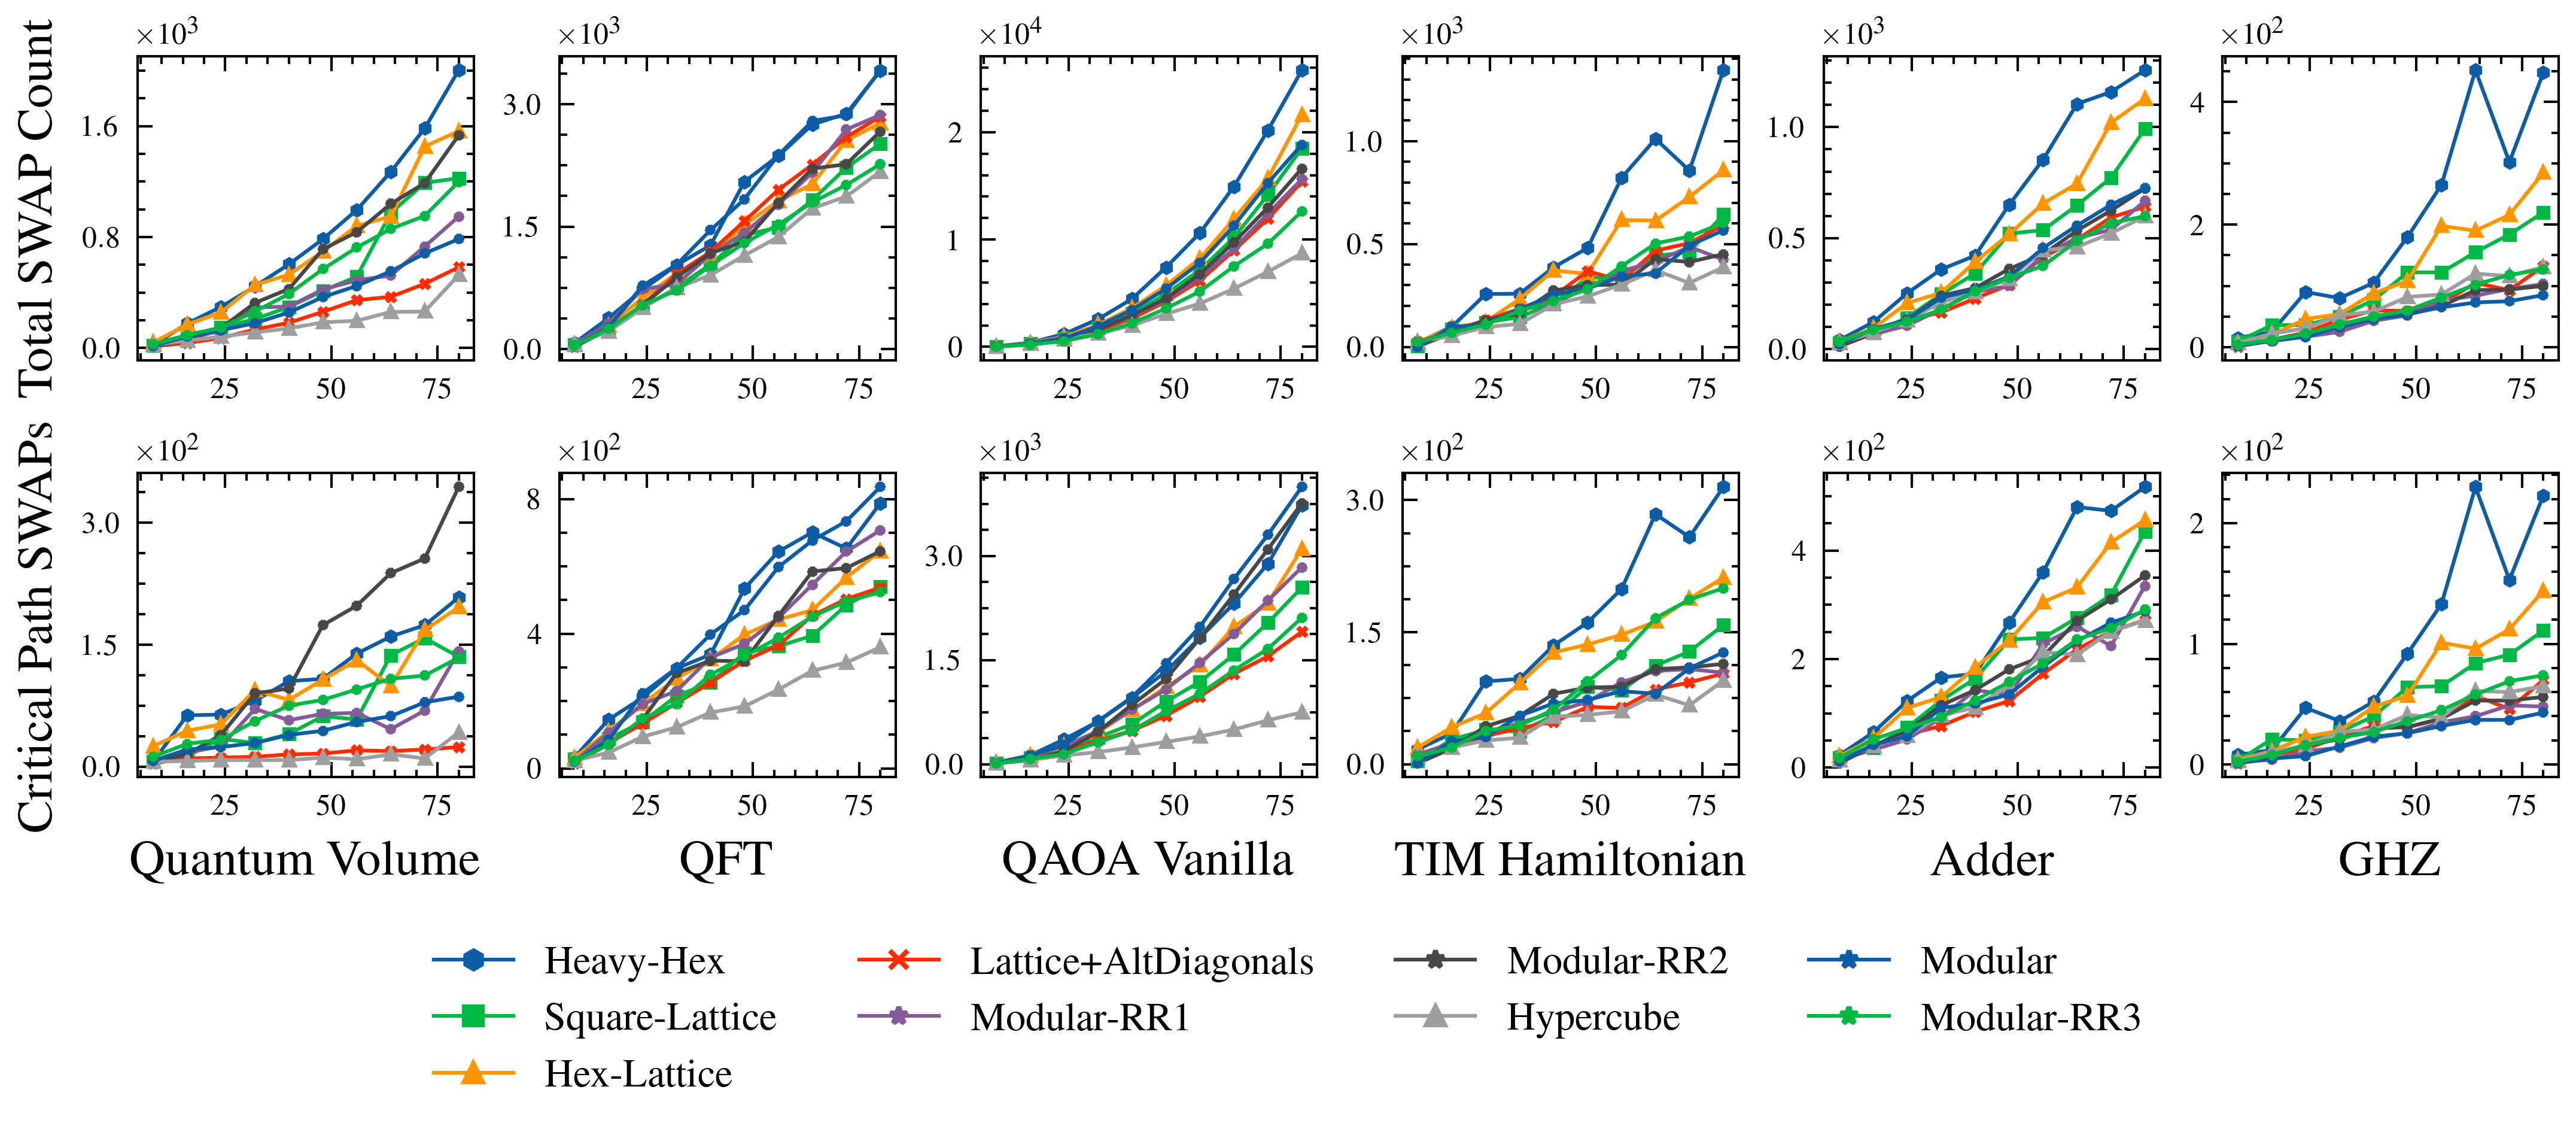

In [22]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

for circuit_gen in circuits.values():
    benchmark(
        backends=motivation_backends,
        circuit_generator=circuit_gen,
        continuously_save=True,
        overwrite=False,
        repeat=1
    )

# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
plot_wrap(motivation_backends, circuits.keys(), motivation=True, plot_average=True)


Starting benchmark for Quantum_Volume
Starting benchmark for Quantum_Volume
Starting benchmark for Quantum_Volume
Starting benchmark for Quantum_Volume
Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QFT
Starting benchmark for QFT
Starting benchmark for QFT
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for QAOA_Vanilla
Starting benchmark for QAOA_Vanilla
Starting benchmark for QAOA_Vanilla
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for TIM_Hamiltonian
Starting benchmark for TIM_Hamiltonian
Starting benchmark for TIM_Hamiltonian
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for Adder
Starting benchmark for Adder
Starting benchmark for Adder
Starting benchmark for Adder
Starting benchmark for GHZ
Starting benchmark for GHZ
Starting benchmark for GHZ
Starting benchmark for GHZ
Starting benchmark for GHZ


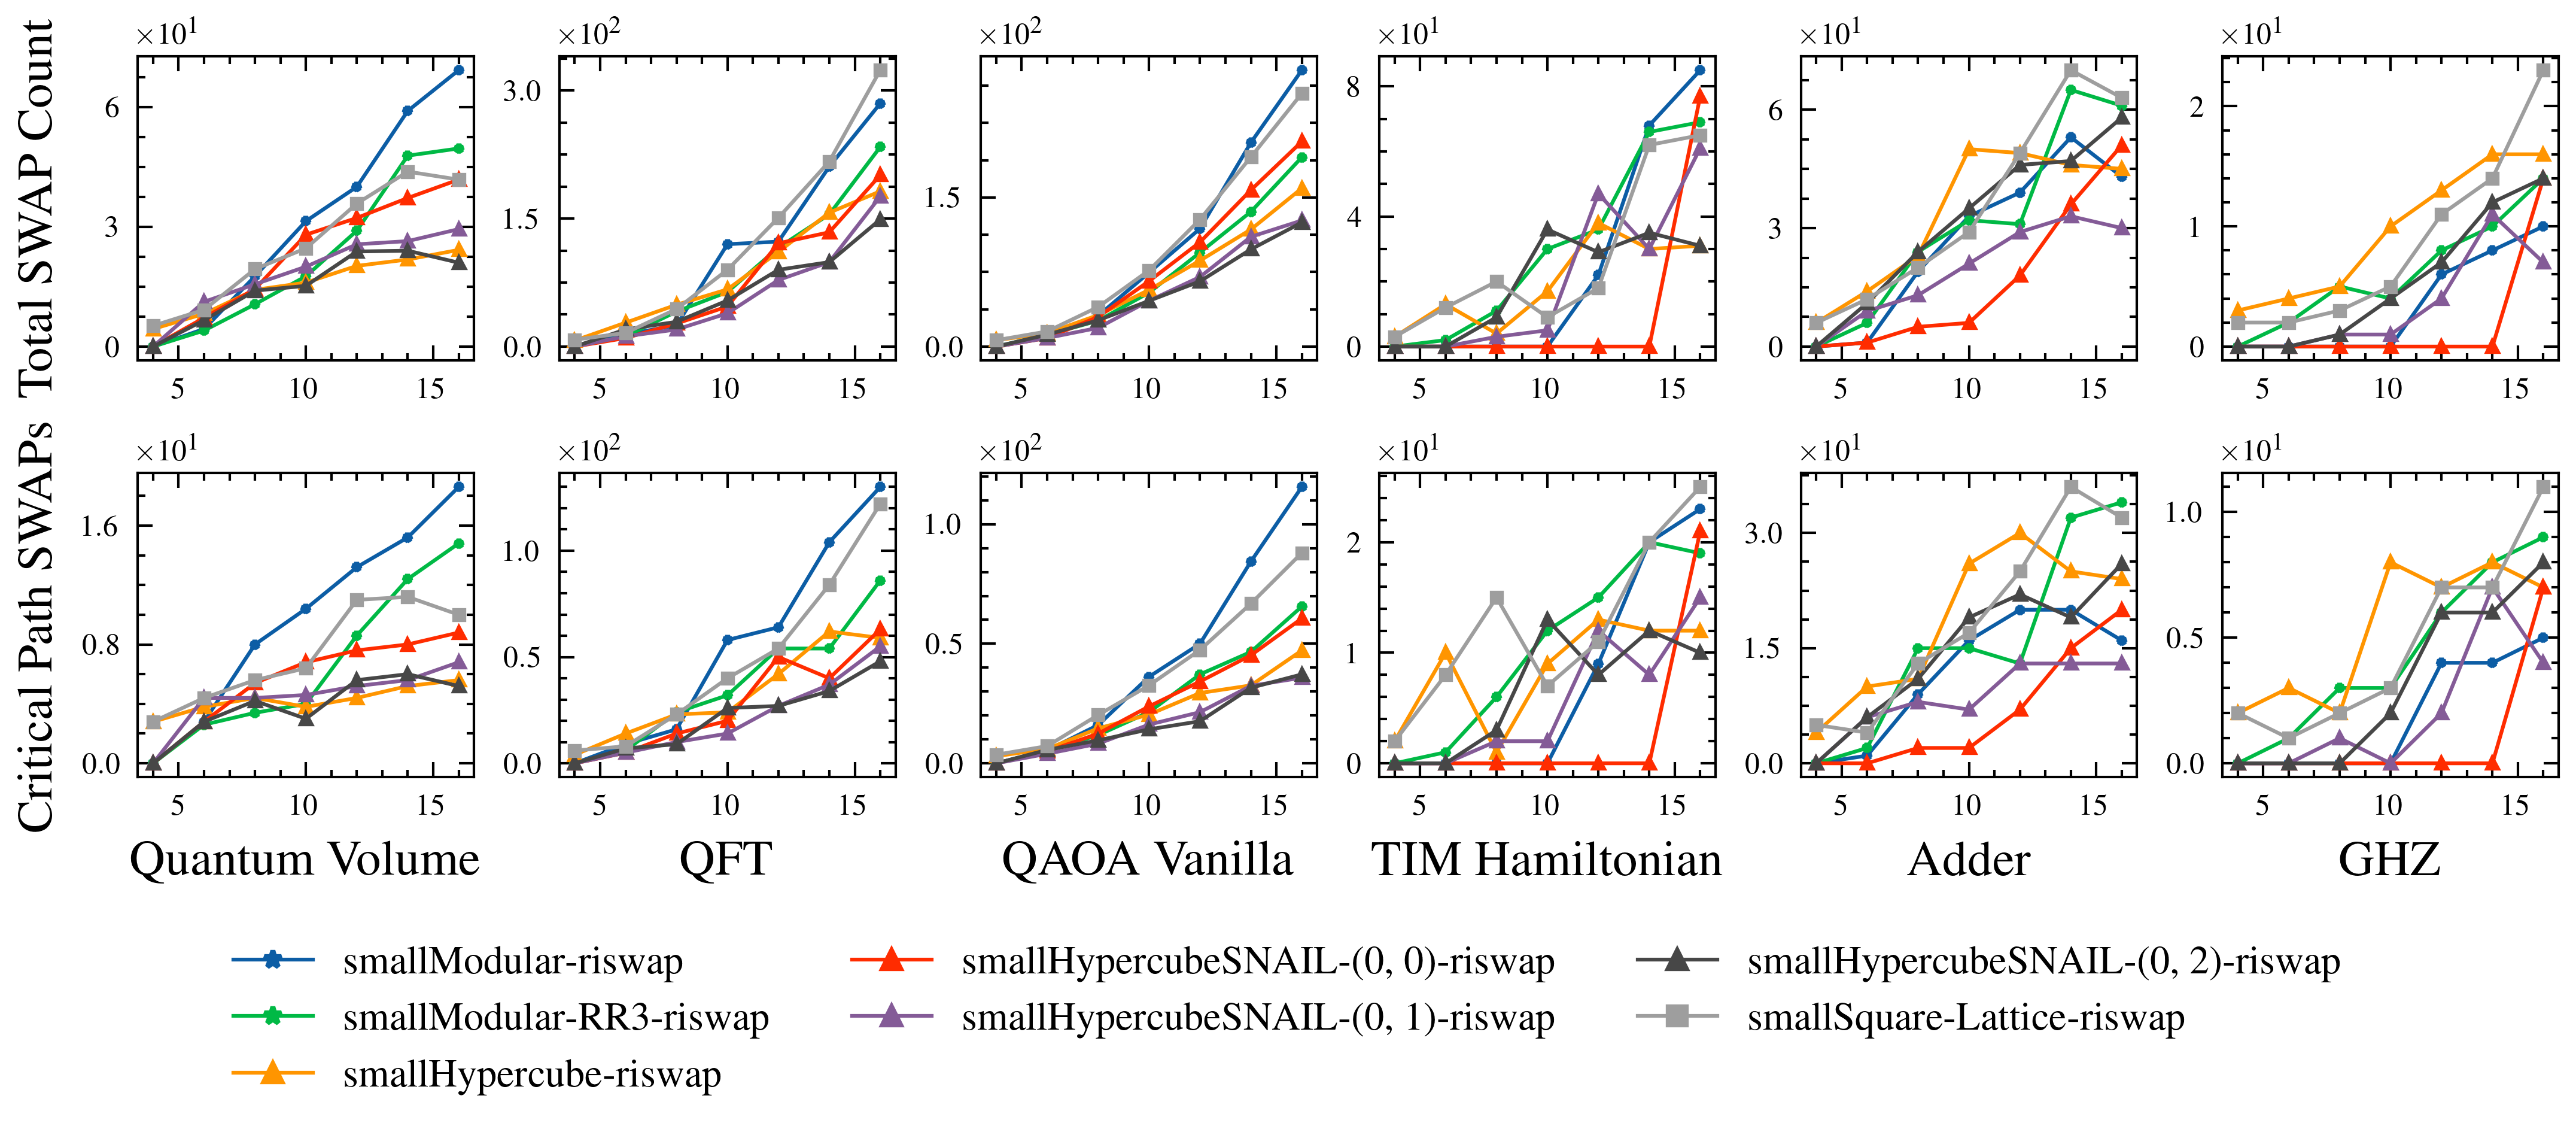

In [21]:
from backend_suite_v2 import small_modular_backends
from circuit_suite import circuits

for circuit_gen in circuits.values():
    benchmark(
        backends=small_modular_backends,
        circuit_generator=circuit_gen,
        continuously_save=True,
        overwrite=False,
        repeat=5
    )

# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
plot_wrap(small_modular_backends, circuits.keys(), motivation=True, plot_average=True)


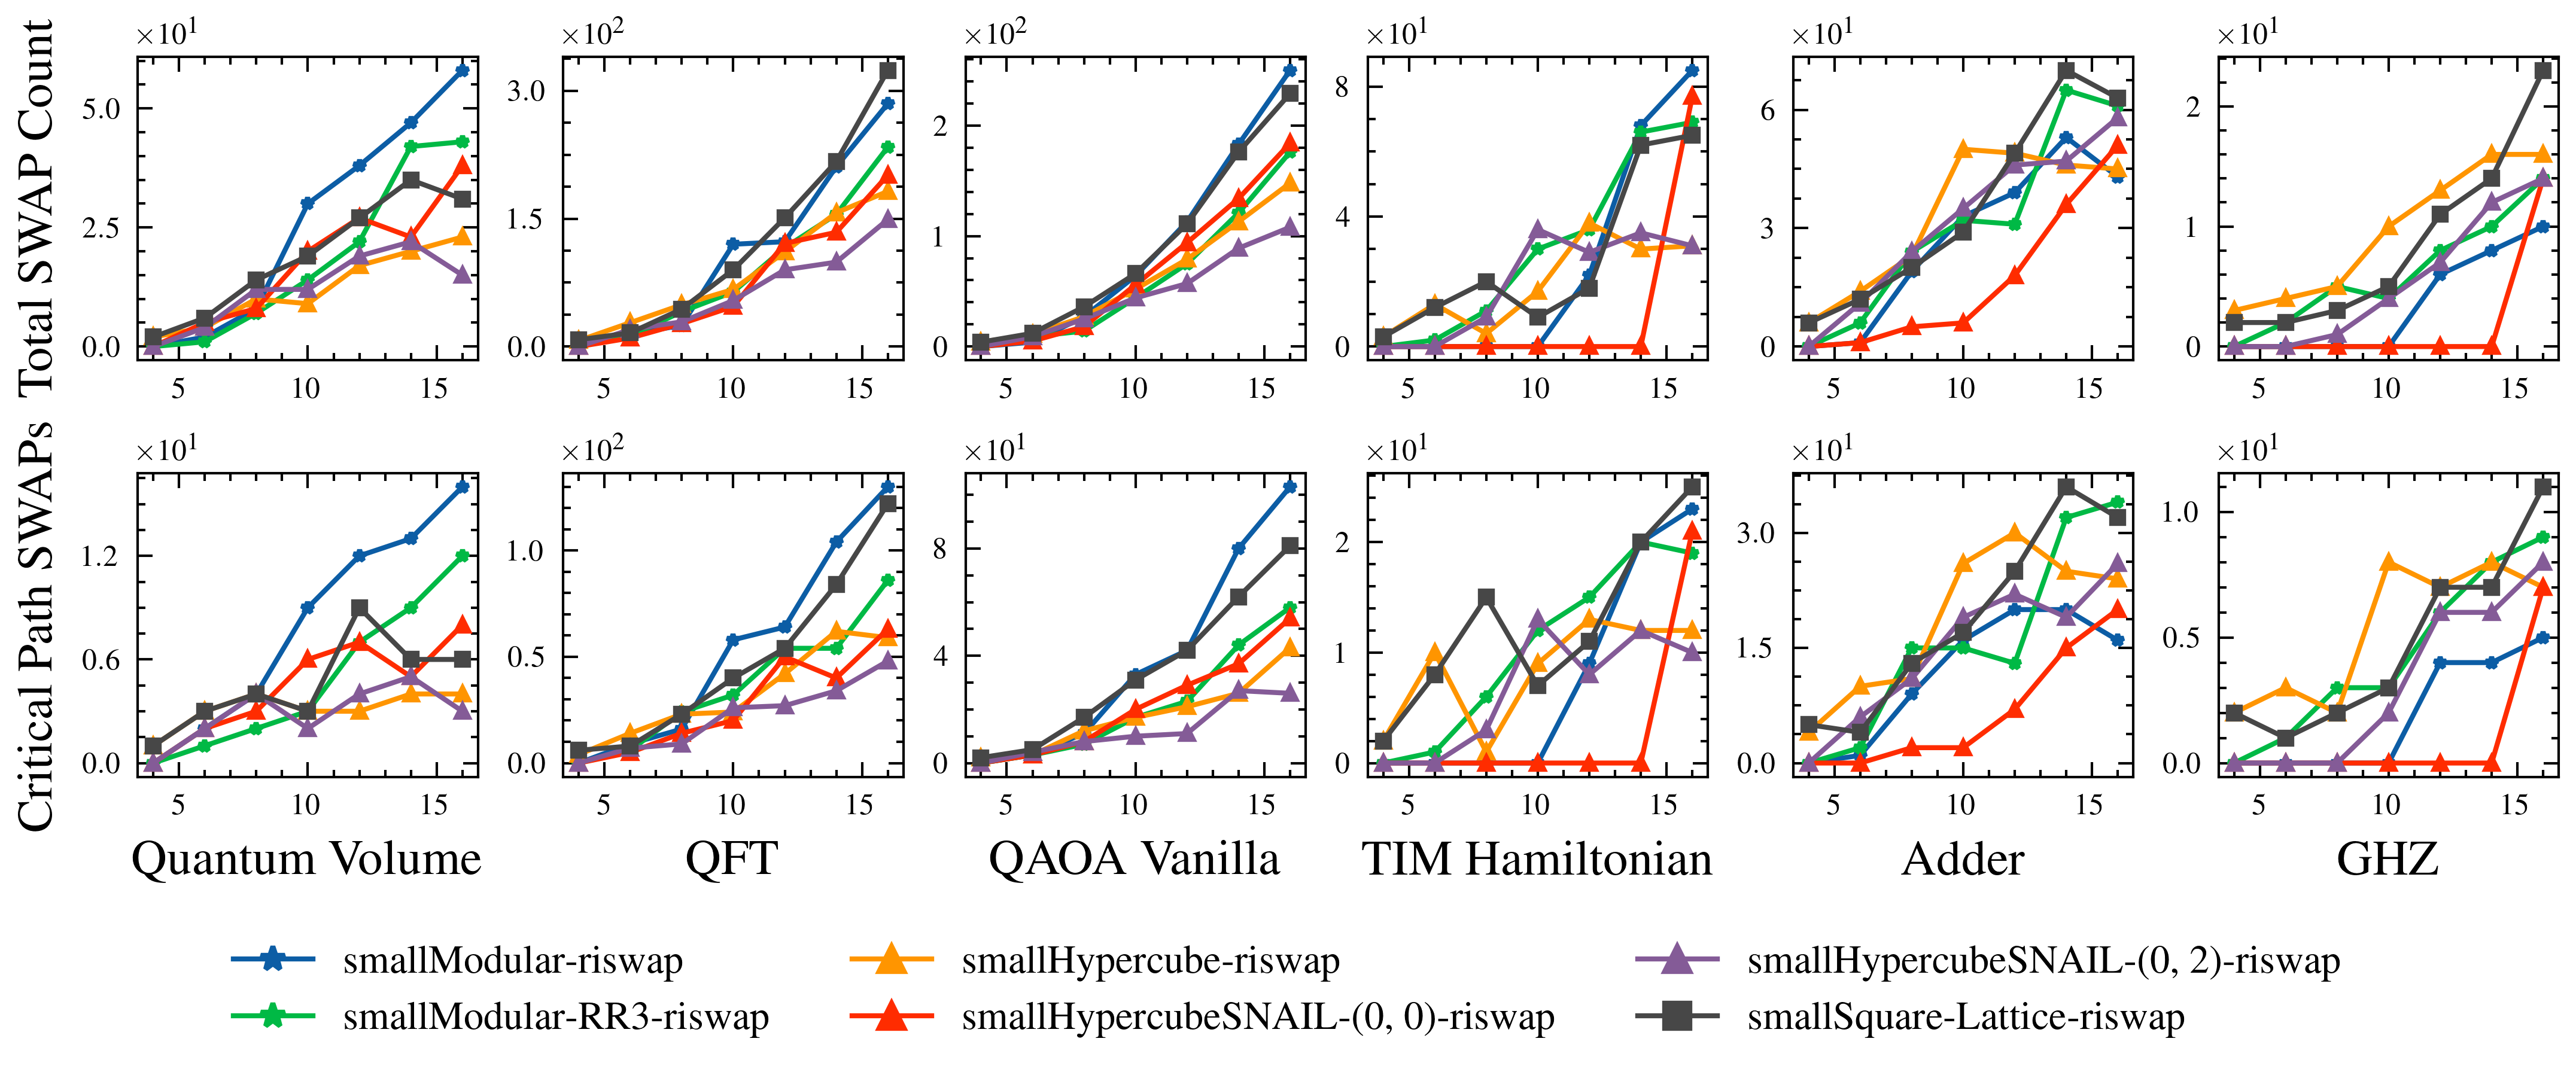

In [24]:
plot_wrap(small_modular_backends, circuits.keys(), motivation=True, plot_average=False)

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rz,x,y,sx,sxdg,reset,measure only apply to a subset of qubits. Using 

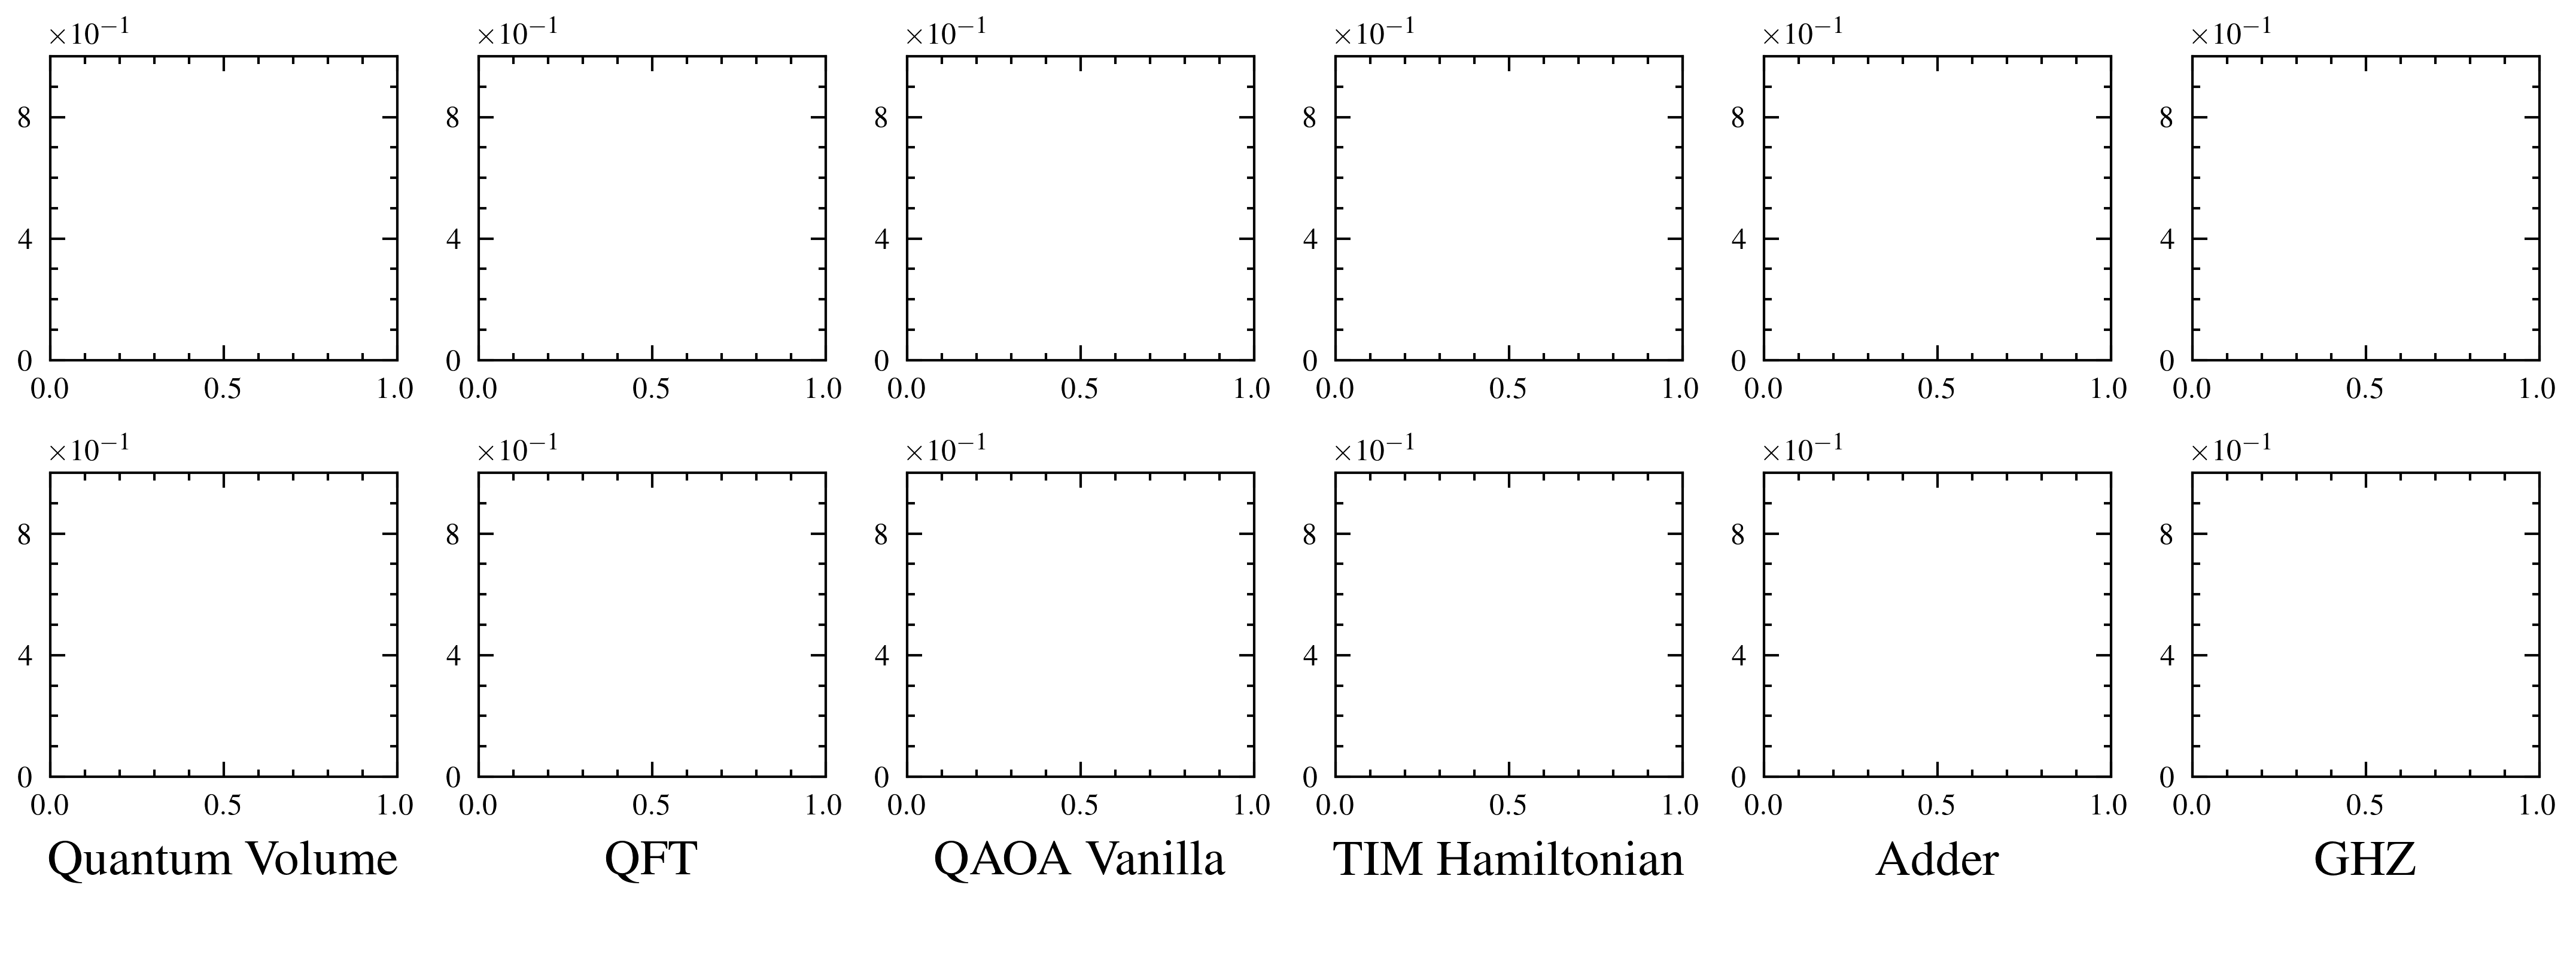

In [18]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

plot_wrap(motivation_backends, circuits.keys(), motivation=True)


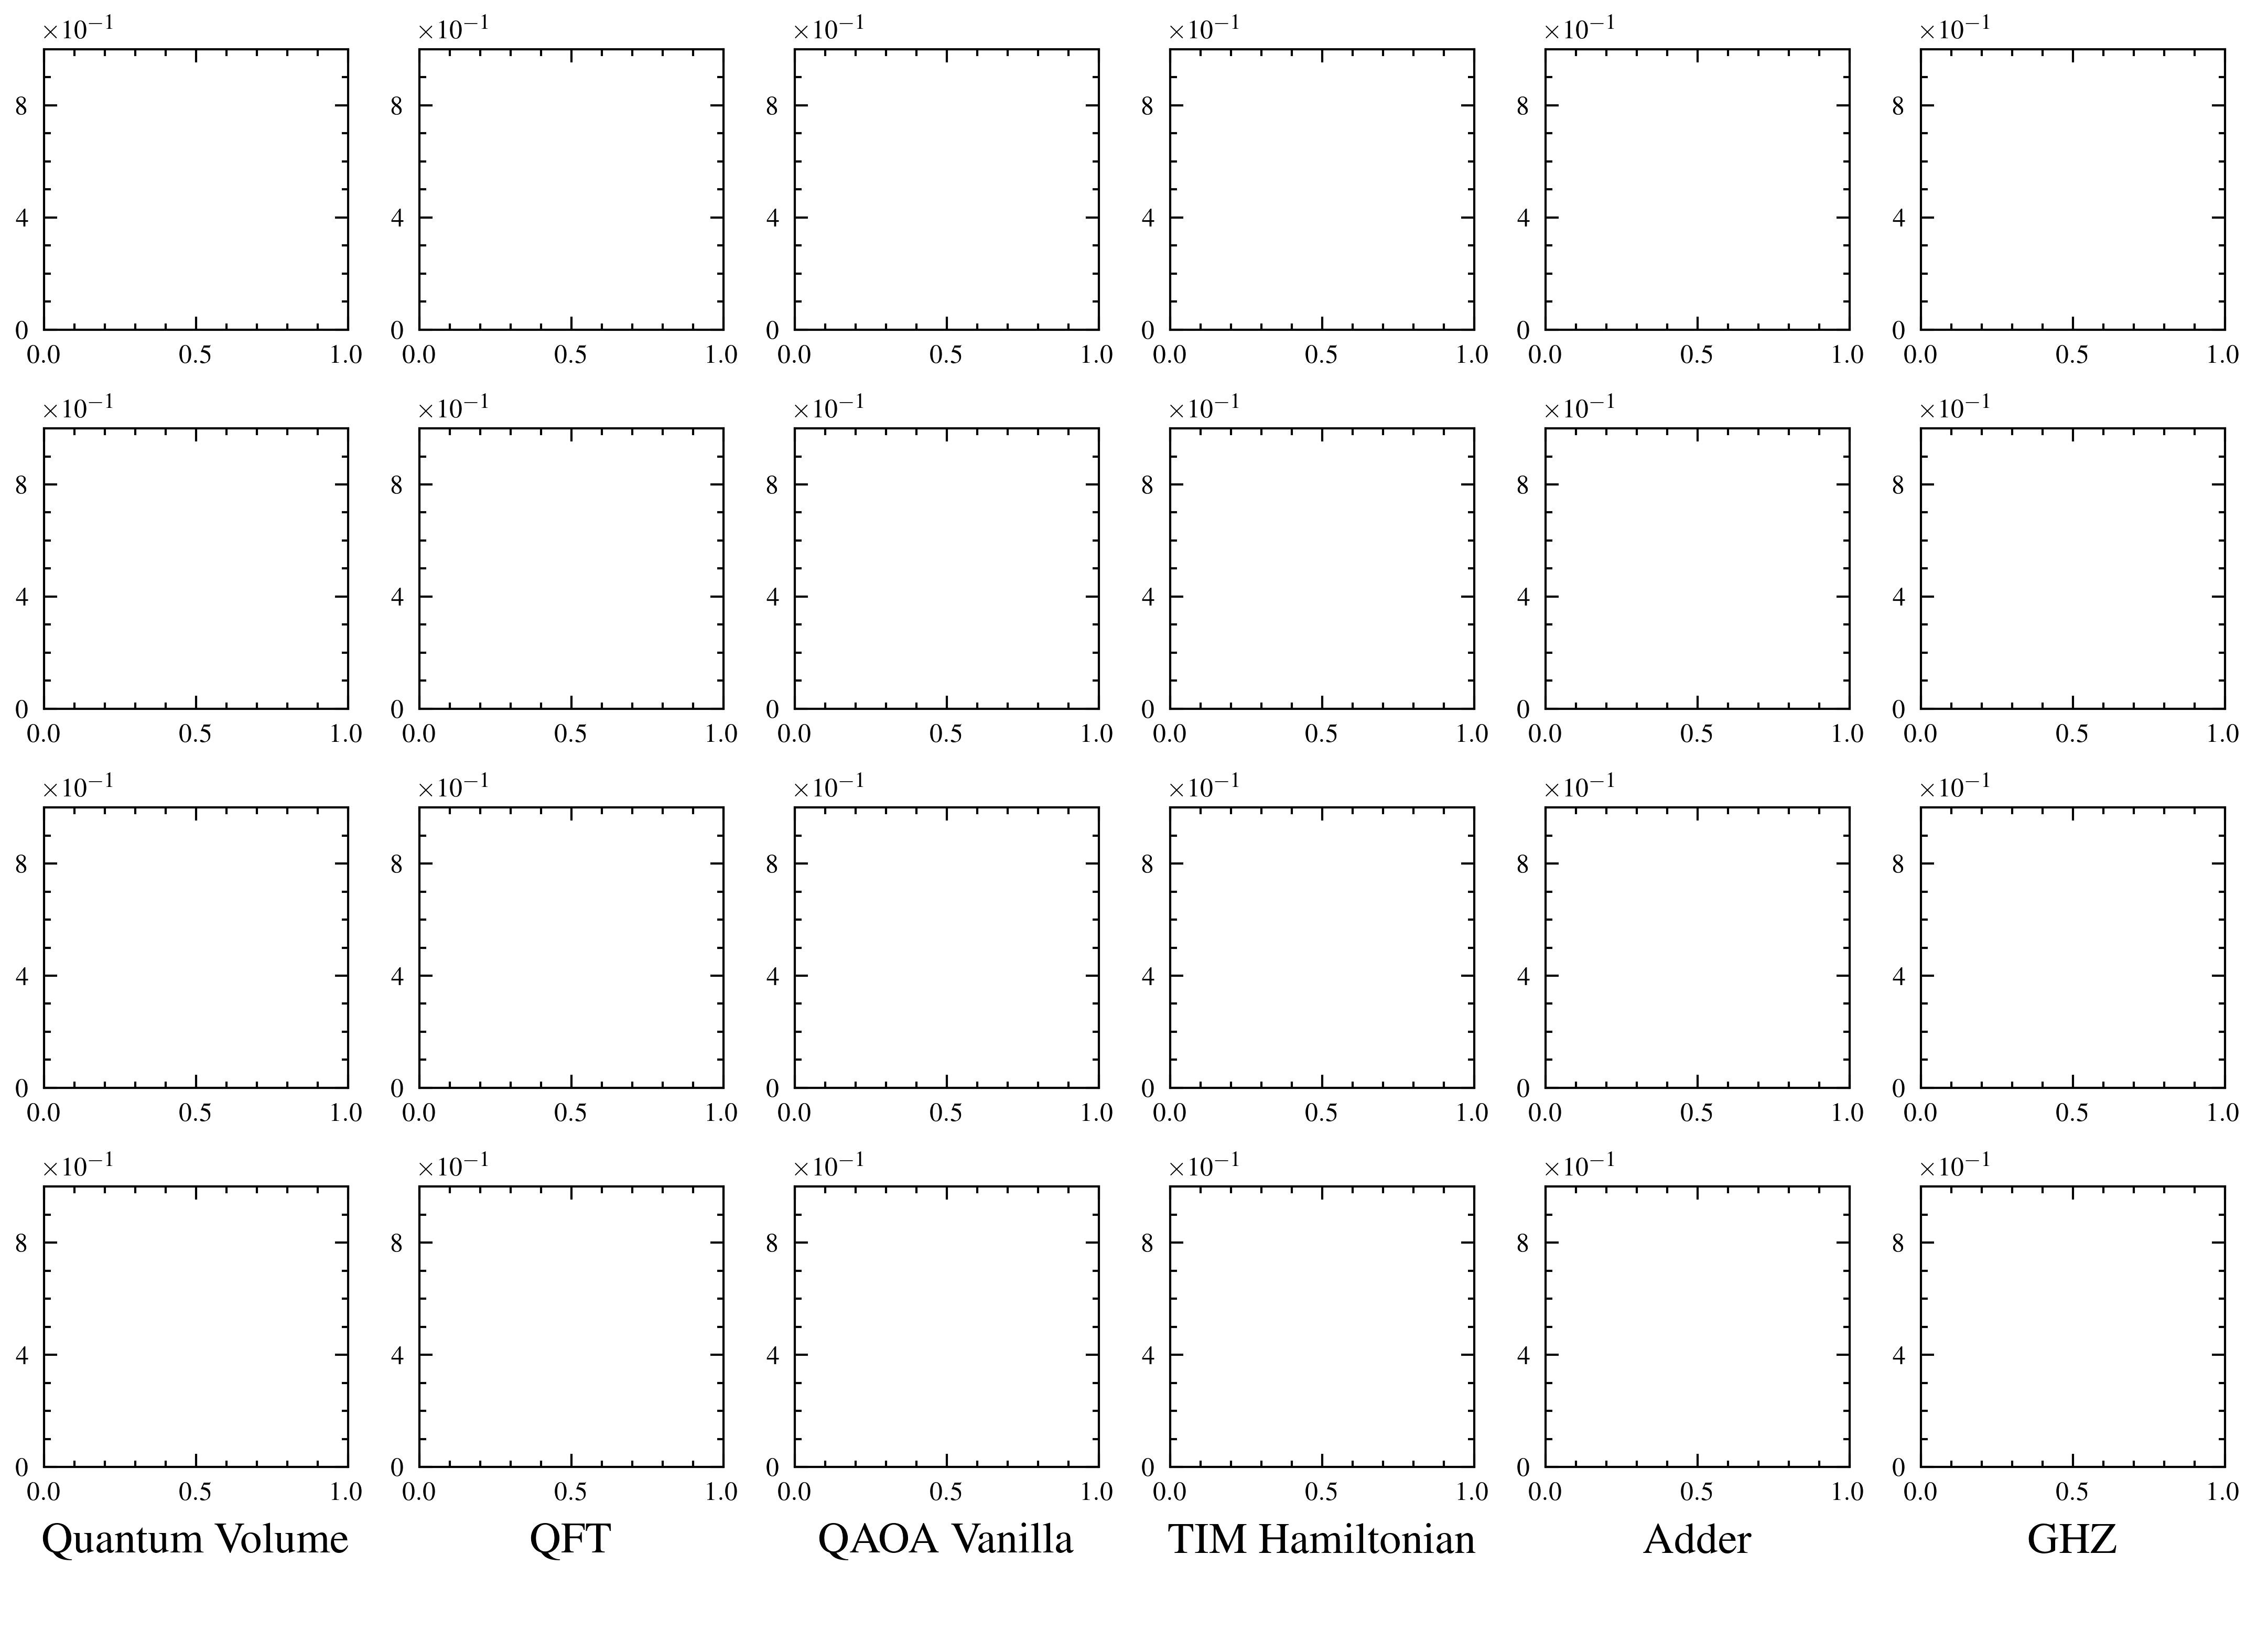

In [19]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

plot_wrap(industry_backends, circuits.keys())


In [9]:
from circuit_suite import circuits
from backend_suite_v2 import transp_tests

benchmark(backends=transp_tests, circuit_generator=circuits["Quantum_Volume"])


Transpiler qc8 for Trivial+Stochastic
Transpiler qc8 for Dense+Basic


KeyError: "The item Qubit(QuantumRegister(115, 'q'), 0) does not exist in the Layout"

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


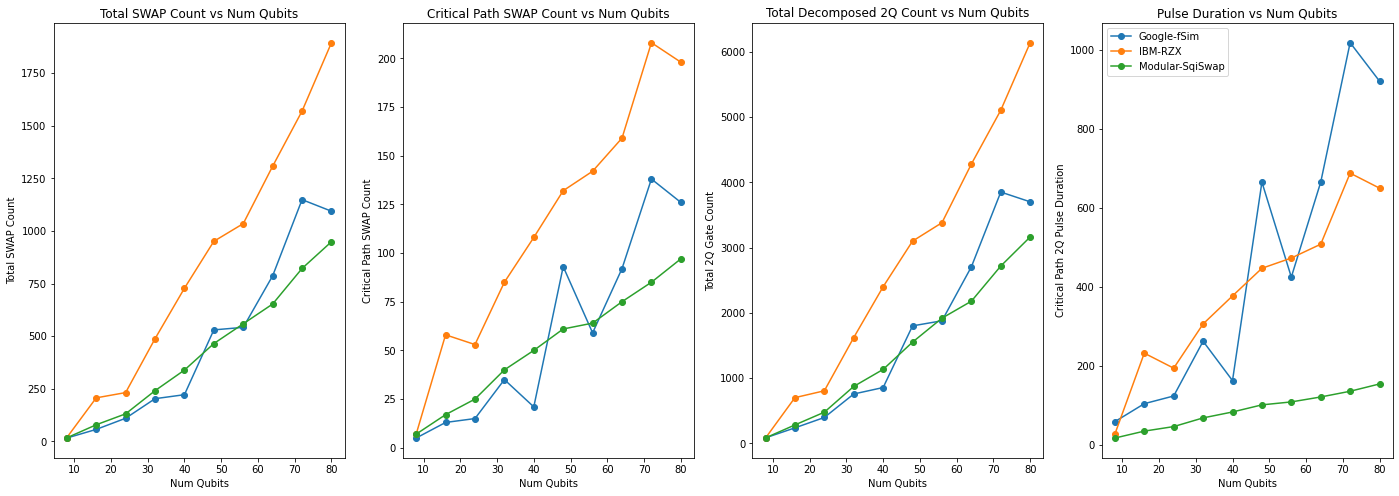

In [5]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


Transpiler qc8 for Google-fSim
Transpiler qc8 for IBM-RZX
Transpiler qc8 for Modular-SqiSwap
Transpiler qc16 for Google-fSim
Transpiler qc16 for IBM-RZX
Transpiler qc16 for Modular-SqiSwap
Transpiler qc24 for Google-fSim
Transpiler qc24 for IBM-RZX
Transpiler qc24 for Modular-SqiSwap
Transpiler qc32 for Google-fSim
Transpiler qc32 for IBM-RZX
Transpiler qc32 for Modular-SqiSwap
Transpiler qc40 for Google-fSim
Transpiler qc40 for IBM-RZX
Transpiler qc40 for Modular-SqiSwap
Transpiler qc48 for Google-fSim
Transpiler qc48 for IBM-RZX
Transpiler qc48 for Modular-SqiSwap
Transpiler qc56 for Google-fSim
Transpiler qc56 for IBM-RZX
Transpiler qc56 for Modular-SqiSwap
Transpiler qc64 for Google-fSim
Transpiler qc64 for IBM-RZX
Transpiler qc64 for Modular-SqiSwap
Transpiler qc72 for Google-fSim
Transpiler qc72 for IBM-RZX
Transpiler qc72 for Modular-SqiSwap
Transpiler qc80 for Google-fSim
Transpiler qc80 for IBM-RZX
Transpiler qc80 for Modular-SqiSwap


<AxesSubplot:title={'center':'Pulse Duration'}, xlabel='Num Qubits'>

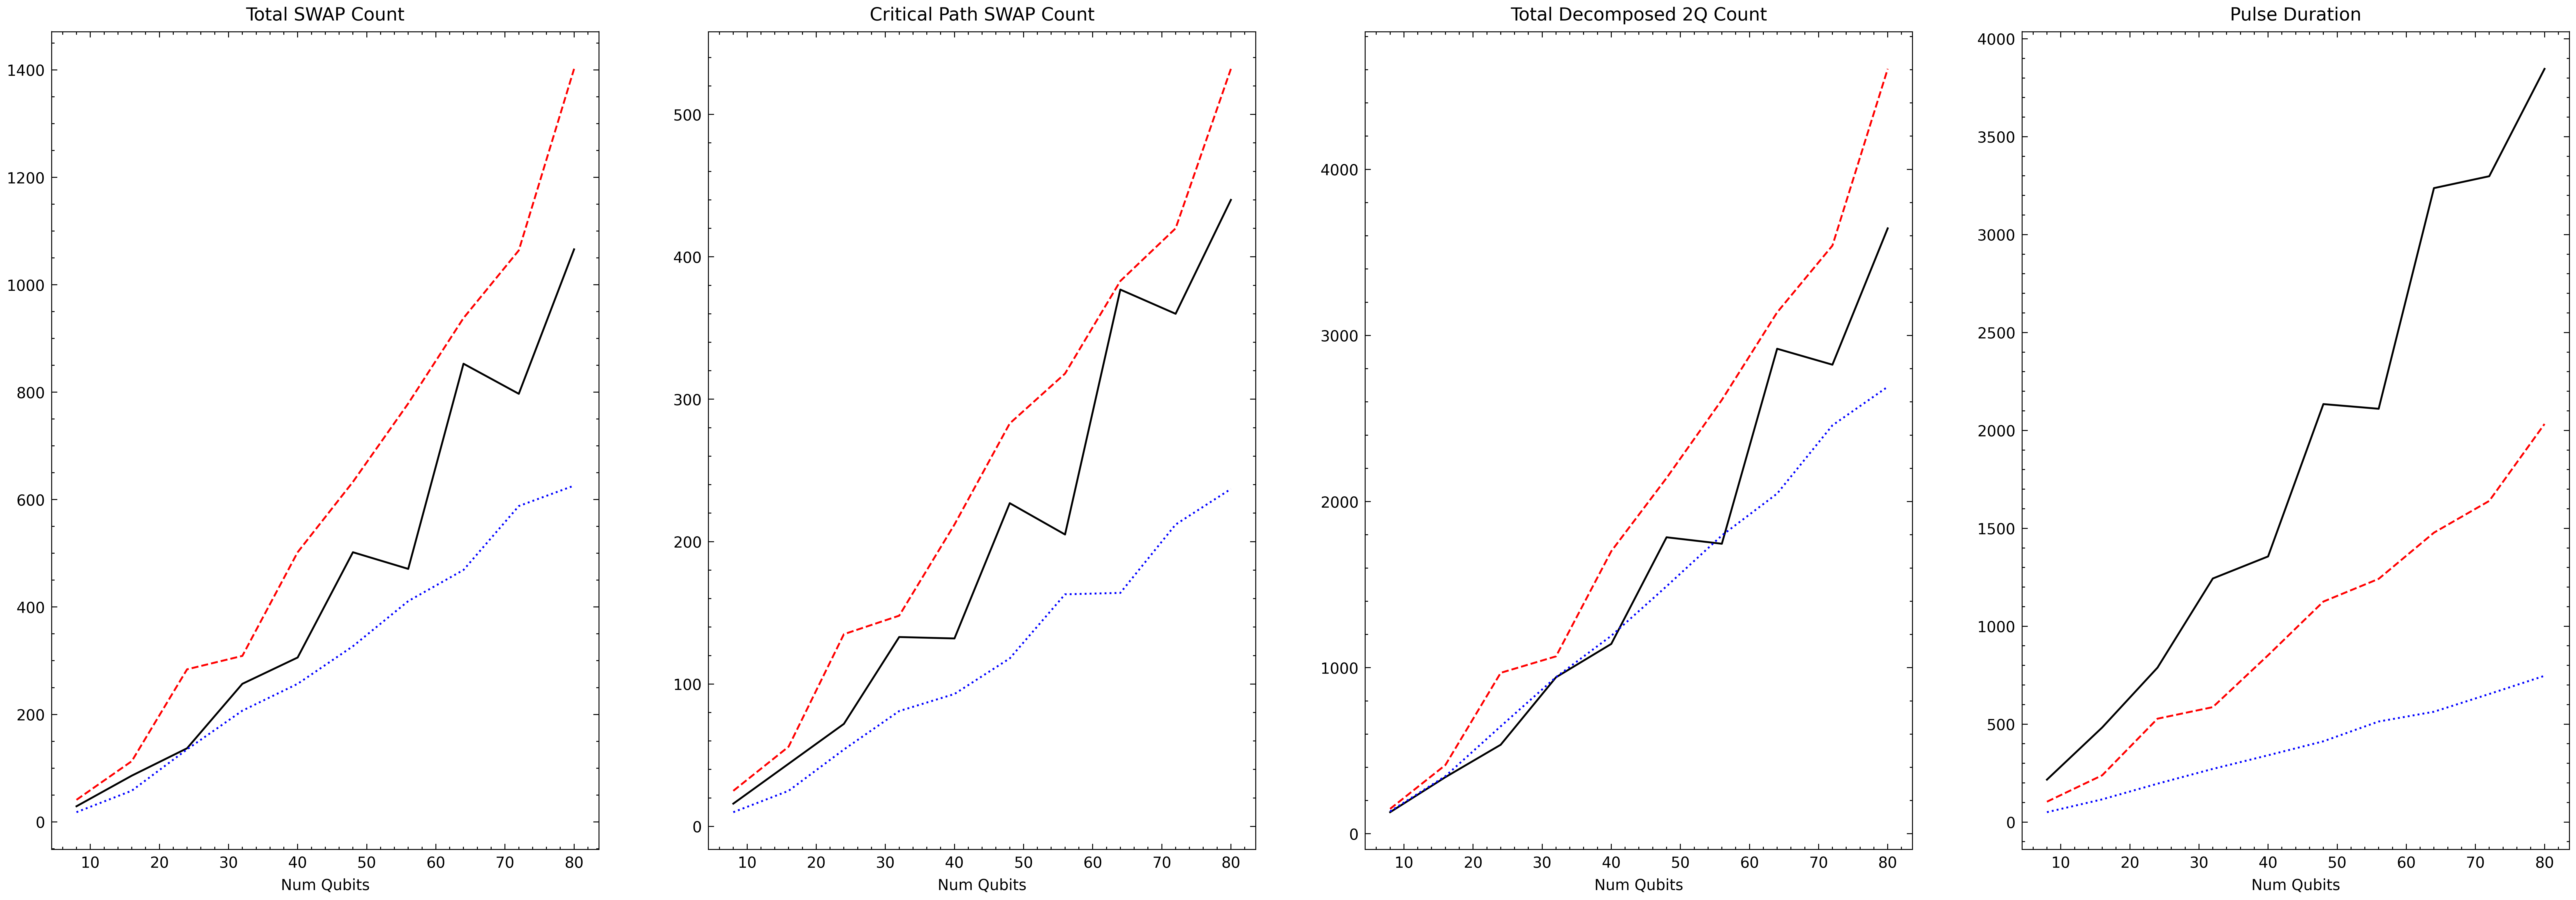

In [56]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


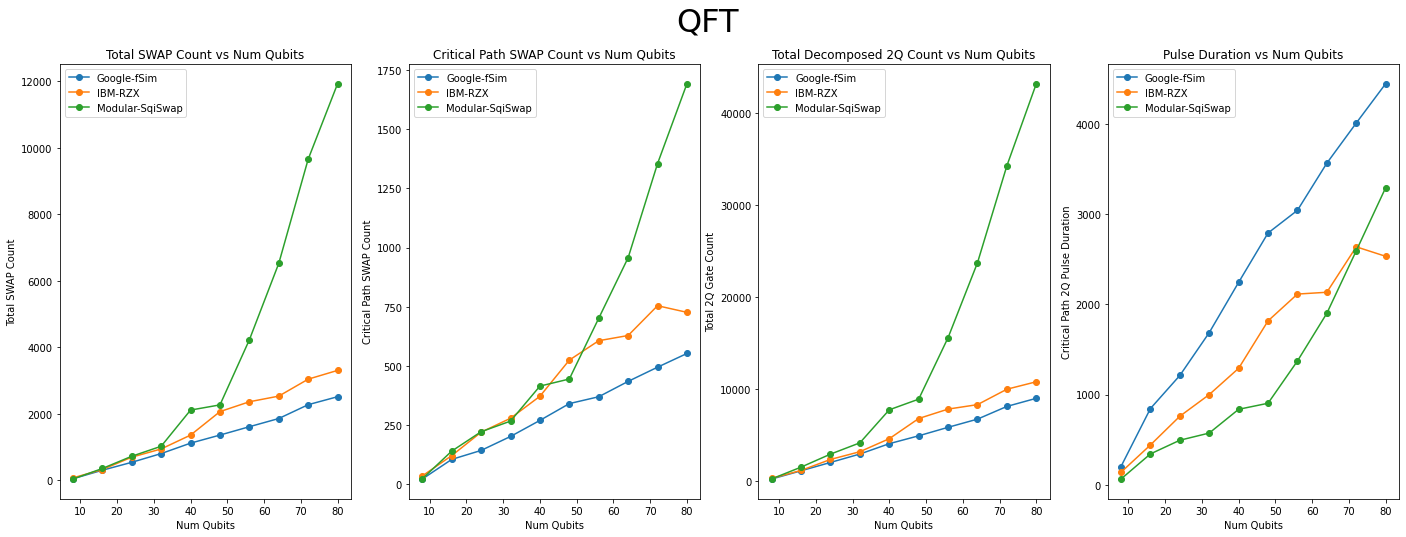

In [9]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["QFT"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


Transpiler qc8 for Google-fSim
Transpiler qc8 for IBM-RZX
Transpiler qc8 for Modular-SqiSwap
Transpiler qc16 for Google-fSim
Transpiler qc16 for IBM-RZX
Transpiler qc16 for Modular-SqiSwap
Transpiler qc24 for Google-fSim
Transpiler qc24 for IBM-RZX
Transpiler qc24 for Modular-SqiSwap
Transpiler qc32 for Google-fSim
Transpiler qc32 for IBM-RZX
Transpiler qc32 for Modular-SqiSwap
Transpiler qc40 for Google-fSim
Transpiler qc40 for IBM-RZX
Transpiler qc40 for Modular-SqiSwap
Transpiler qc48 for Google-fSim
Transpiler qc48 for IBM-RZX
Transpiler qc48 for Modular-SqiSwap
Transpiler qc56 for Google-fSim
Transpiler qc56 for IBM-RZX
Transpiler qc56 for Modular-SqiSwap
Transpiler qc64 for Google-fSim
Transpiler qc64 for IBM-RZX
Transpiler qc64 for Modular-SqiSwap
Transpiler qc72 for Google-fSim
Transpiler qc72 for IBM-RZX
Transpiler qc72 for Modular-SqiSwap
Transpiler qc80 for Google-fSim
Transpiler qc80 for IBM-RZX
Transpiler qc80 for Modular-SqiSwap


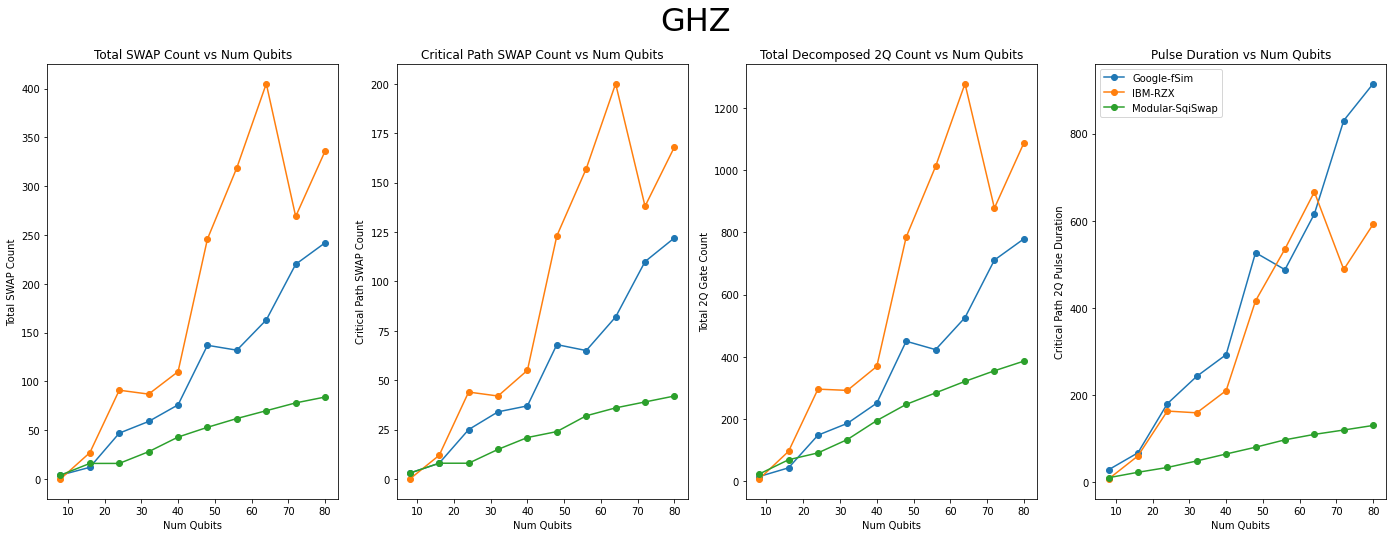

In [12]:
from backend_suite_v2 import industry_backends
from circuit_suite import circuits

circuit_gen = circuits["GHZ"]
benchmark(
    backends=industry_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(industry_backends, circuit_gen.label, duration=2)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


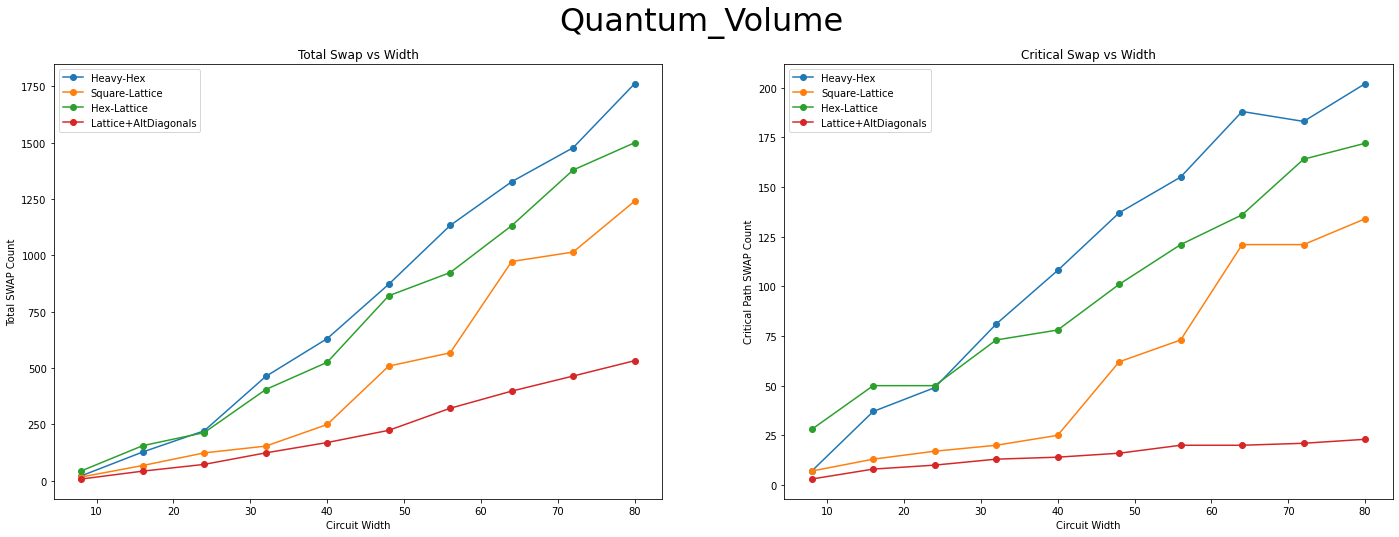

In [10]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [1]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["QAOA_Vanilla"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


NameError: name 'benchmark' is not defined

In [ ]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [ ]:
from backend_suite_v2 import motivation_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=motivation_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(motivation_backends, circuit_gen.label, duration=False)
# edge_histogram(decomp_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


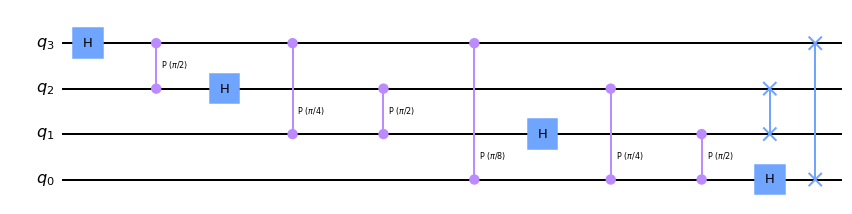

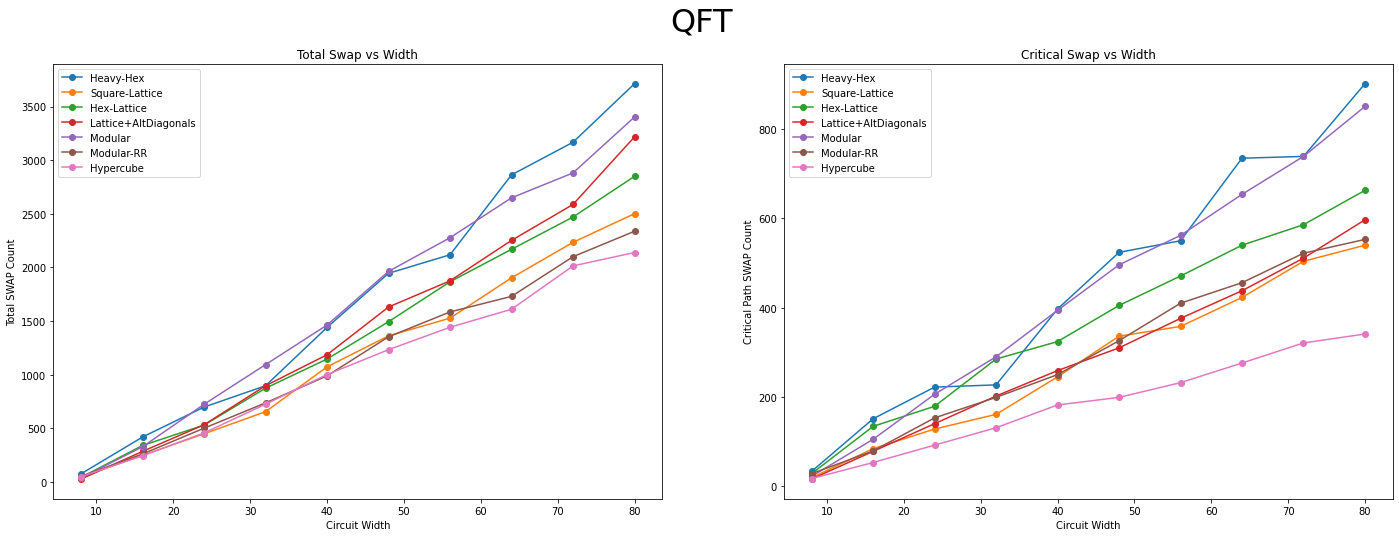

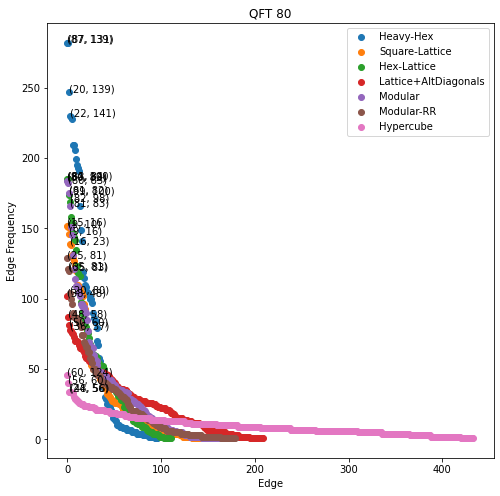

In [15]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["QFT"]
benchmark(
    backends=topology_backends,
    circuit_generator=circuit_gen,
    continuously_save=True,
    overwrite=False,
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


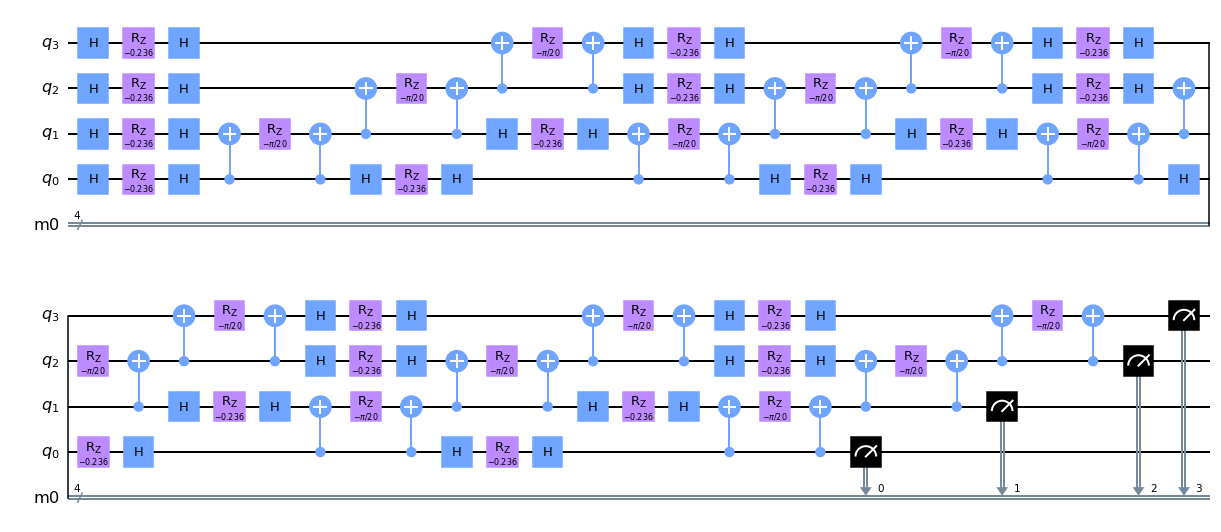

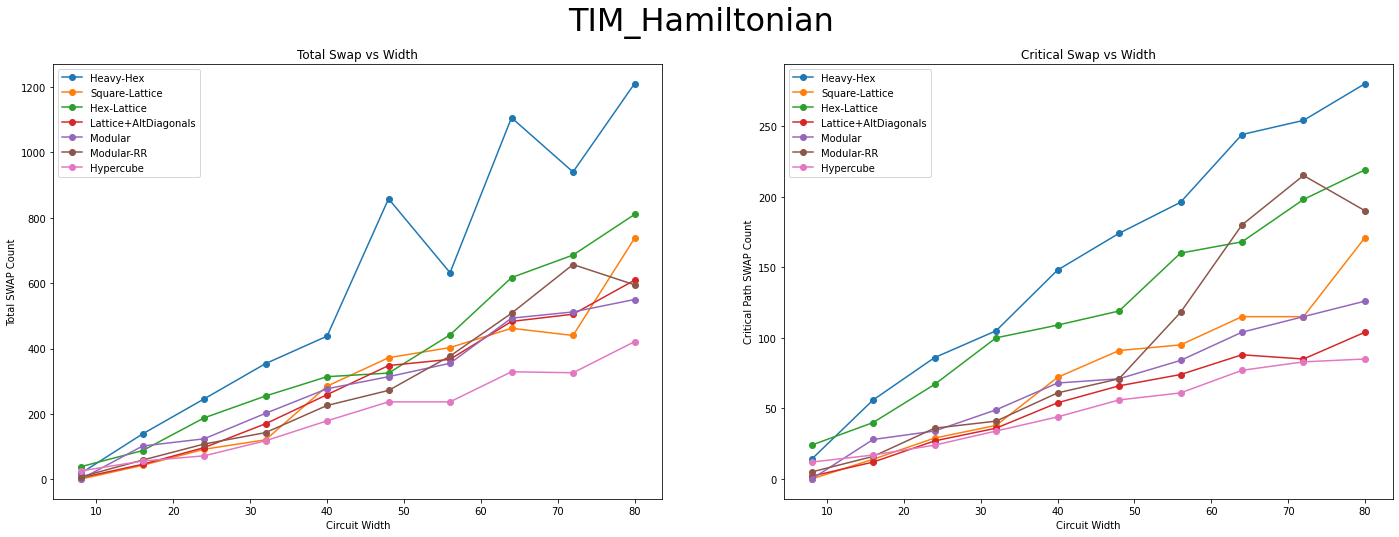

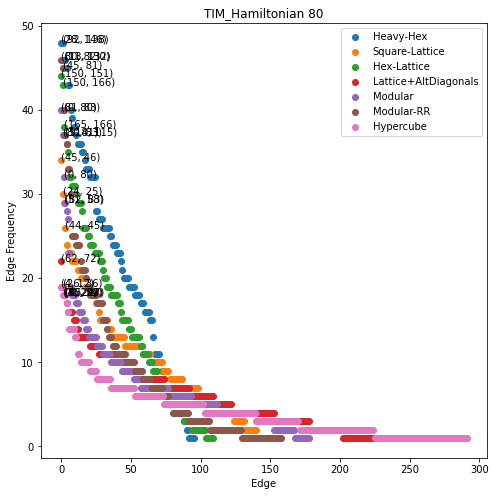

In [16]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


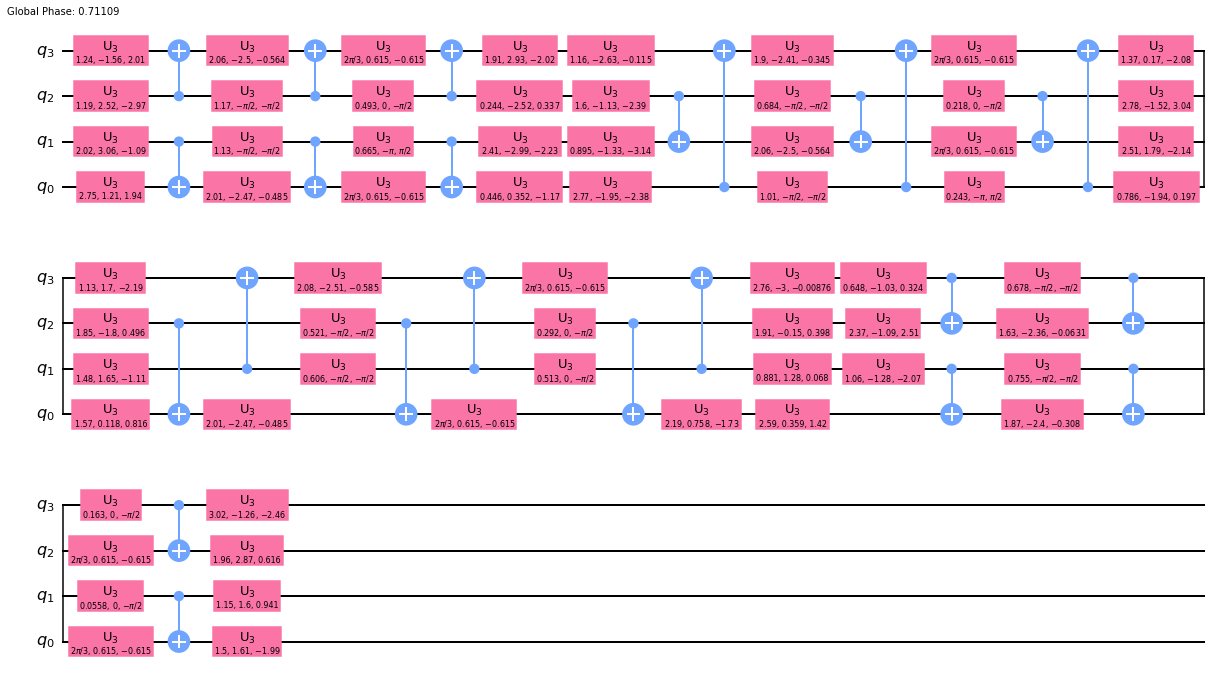

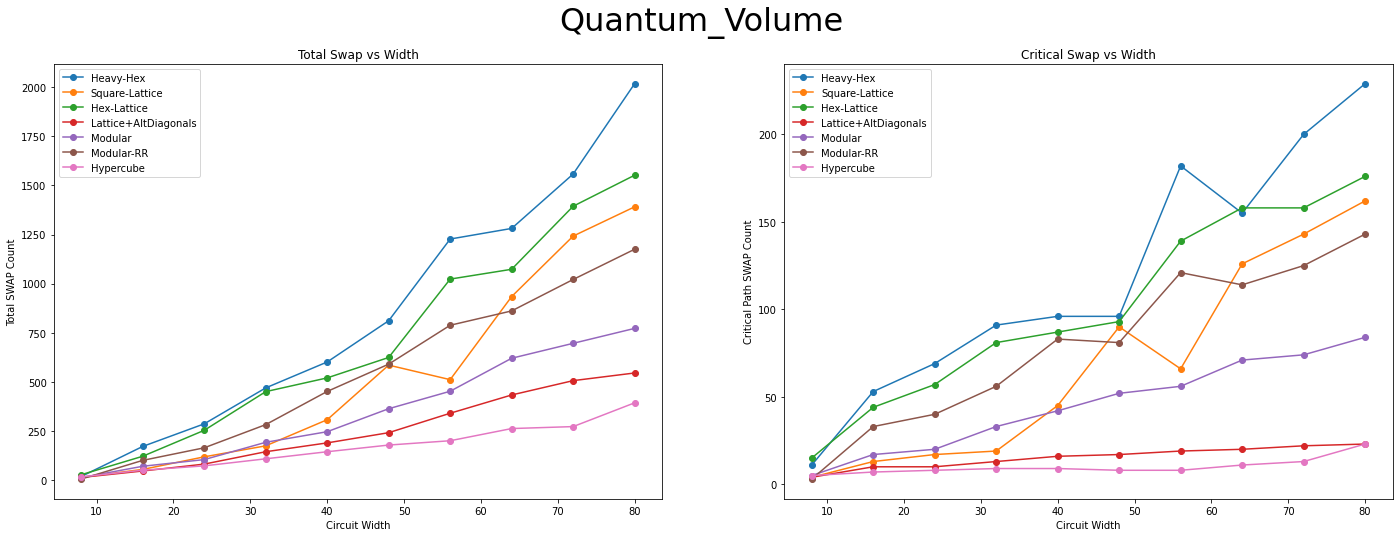

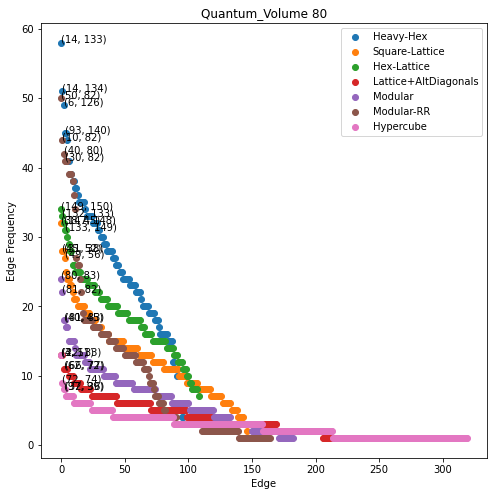

In [17]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["Quantum_Volume"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).decompose().decompose().draw(
    output="mpl", reverse_bits=True
)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


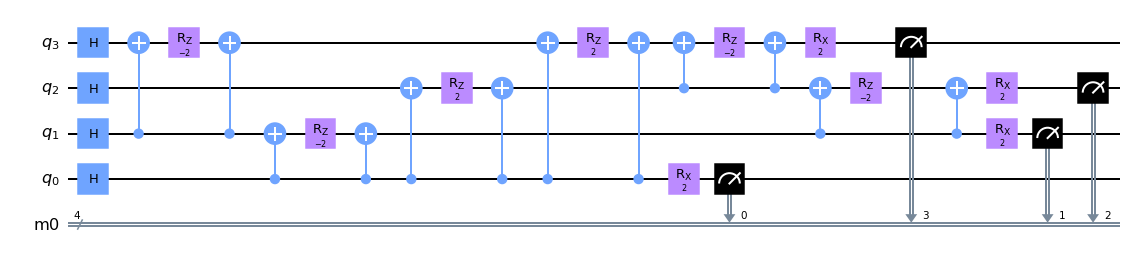

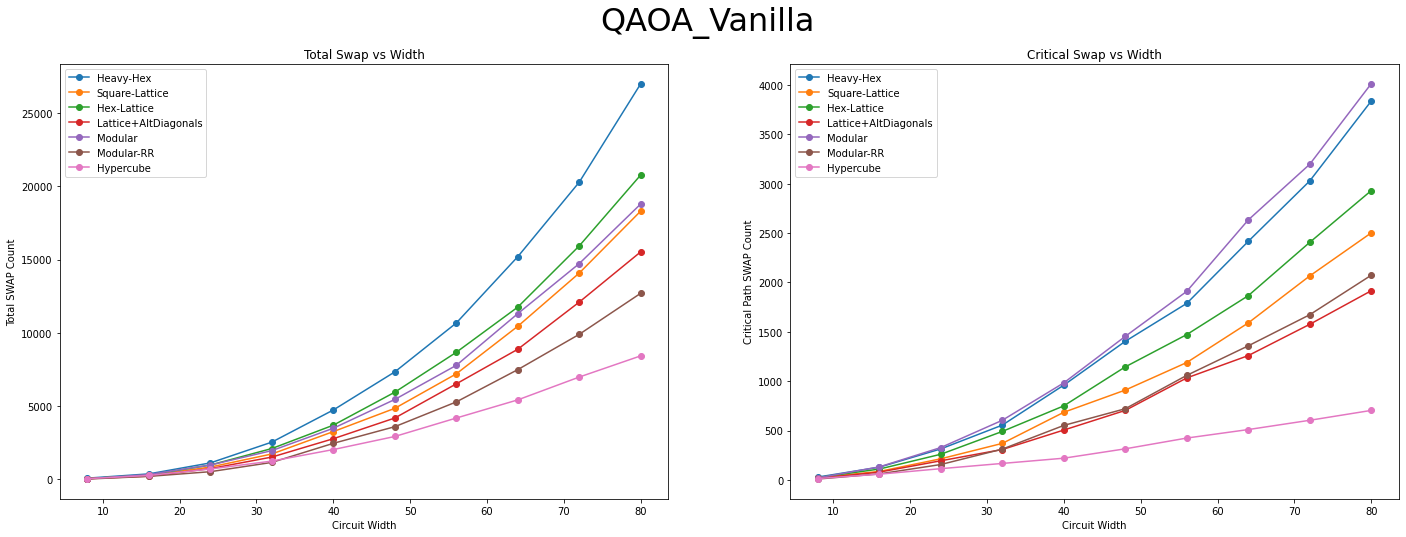

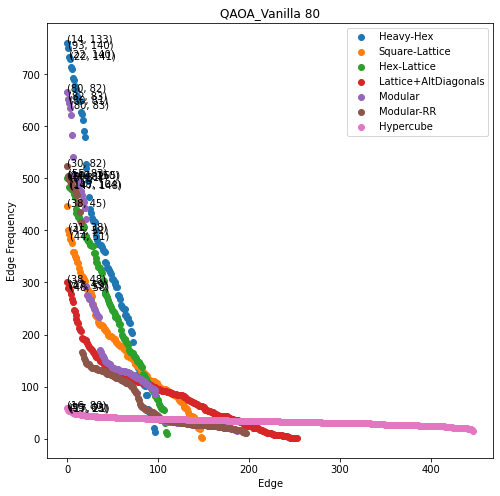

In [18]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["QAOA_Vanilla"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


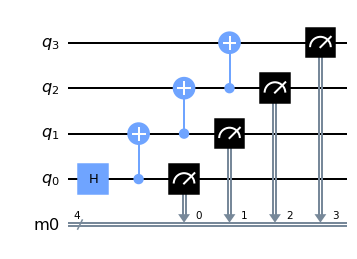

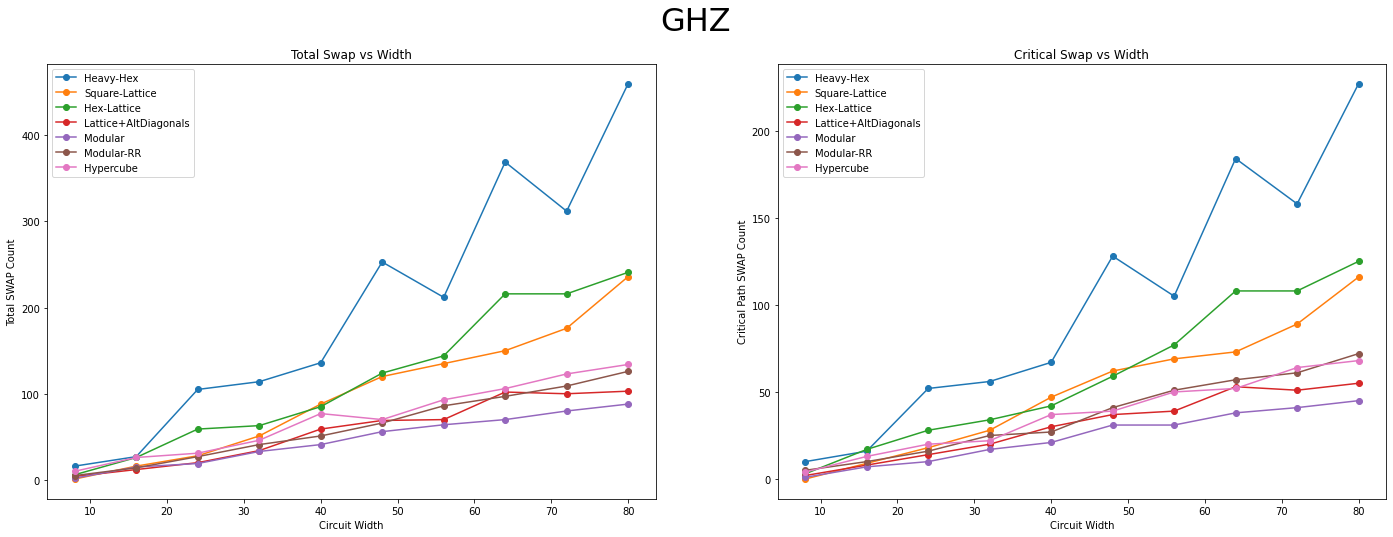

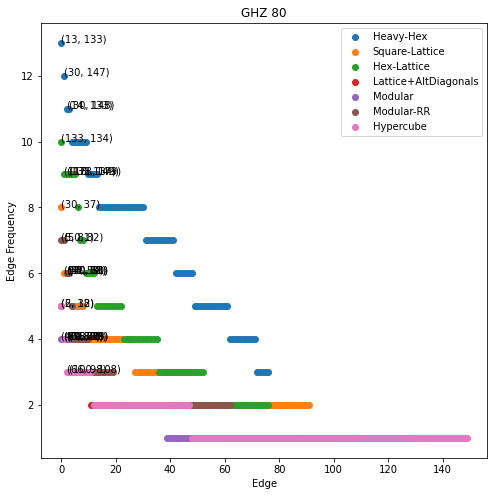

In [19]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["GHZ"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Transpiler qc40 for Heavy-Hex
Transpiler qc40 for Square-Lattice
Transpiler qc40 for Hex-Lattice
Transpiler qc40 for Lattice+AltDiagonals
Transpiler qc40 for Modular
Transpiler qc40 for Modular-RR
Transpiler qc40 for Hypercube
Transpiler qc56 for Heavy-Hex
Transpiler qc56 for Square-Lattice
Transpiler qc56 for Hex-Lattice
Transpiler qc56 for Lattice+AltDiagonals
Transpiler qc56 for Modular
Transpiler qc56 for Modular-RR
Transpiler qc56 for Hypercube
Transpiler qc72 for Heavy-Hex
Transpiler qc72 for Square-Lattice
Transpiler qc72 for Hex-Lattice
Transpiler qc72 for Lattice+AltDiagonals
Transpiler qc72 for Modular
Transpiler qc72 for Modular-RR
Transpiler qc72 for Hypercube


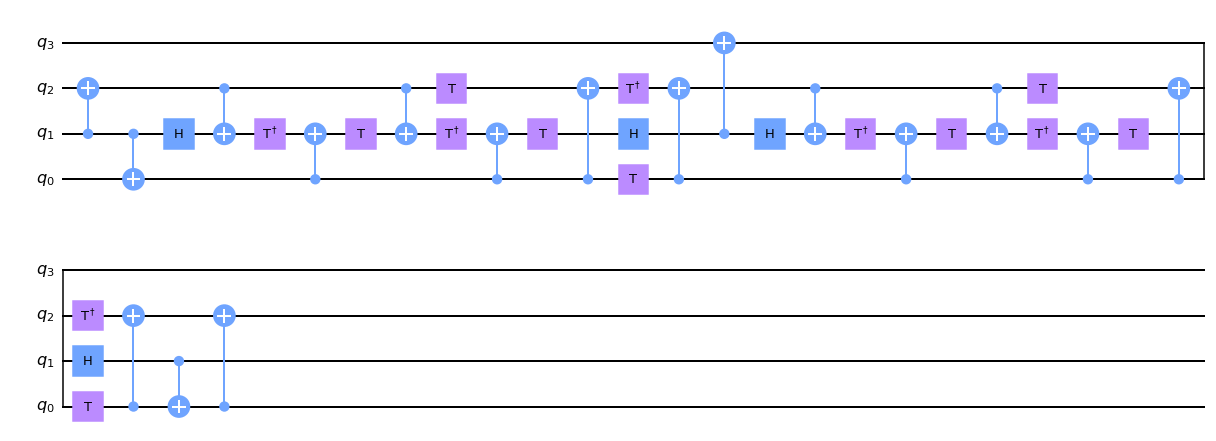

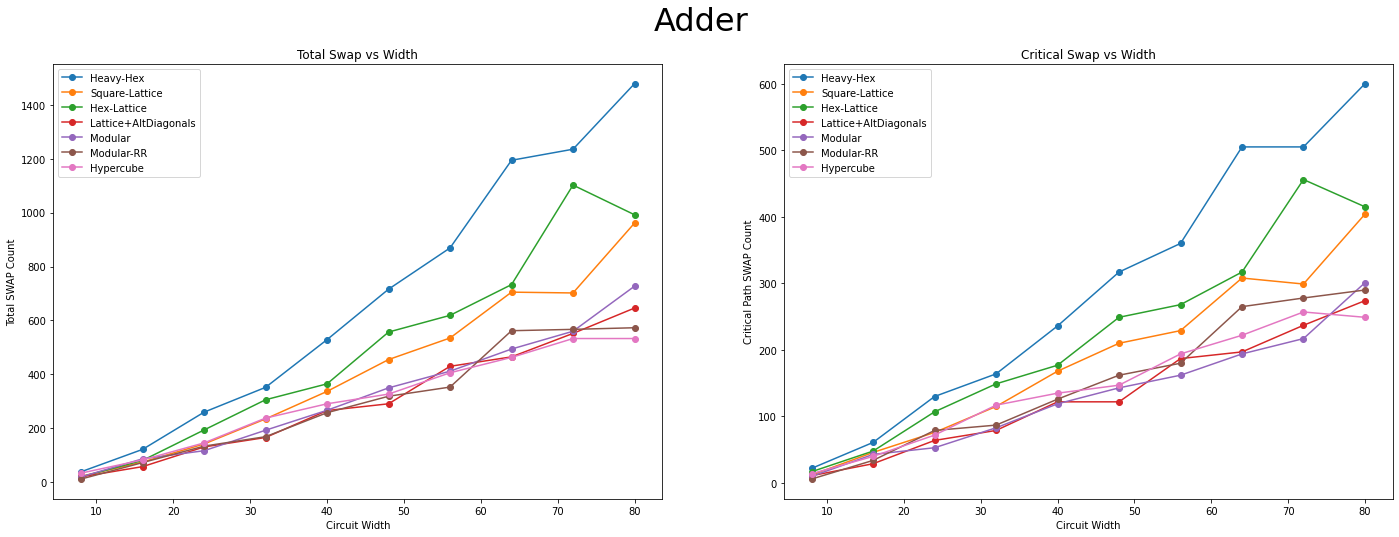

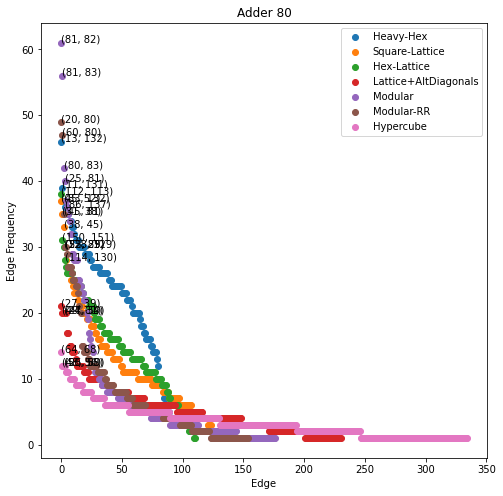

In [20]:
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

circuit_gen = circuits["Adder"]
benchmark(
    backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True
)
plot(topology_backends, circuit_gen.label)
edge_histogram(topology_backends, circuit_gen.label)
circuit_gen.circuit_lambda(4).draw(output="mpl", reverse_bits=True)


Text(0.5, 0.98, 'Topology Parameters as predictors for transpilation success')

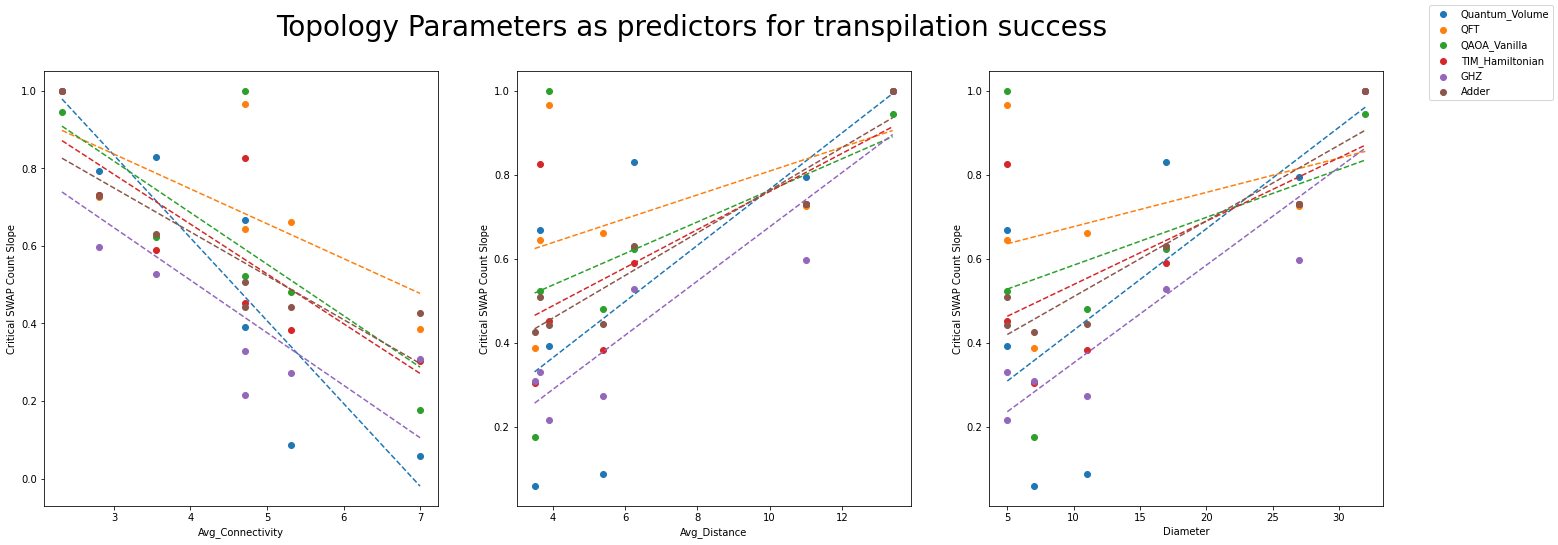

In [58]:
# try and do some data analysis
# requires backend_analysis_main.ipynb to be ran first
from matplotlib import pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
from backend_suite_v2 import topology_backends
from circuit_suite import circuits

for circuit_label in circuits.keys():
    # for circuit_label in ["GHZ"]:
    slope_list = []
    backend_property1 = []
    backend_property2 = []
    backend_property3 = []
    for backend in topology_backends:
        x = backend.data[circuit_label]["gate_count_crit"].keys()
        x = [int(el) for el in list(x)]
        y = backend.data[circuit_label]["gate_count_crit"].values()
        x, y = zip(*zip(x, y))
        y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
        x, y = zip(*sorted(zip(x, y)))
        from scipy.stats import linregress

        slope_list.append(linregress(x, y).slope)
        backend_property1.append(
            backend.data["Avg_Connectivity"]
        )  # Diameter, Avg_Distance, Avg_Connectivity
        backend_property2.append(backend.data["Avg_Distance"])
        backend_property3.append(backend.data["Diameter"])
        # backend_property3.append(backend.data["Avg_Connectivity"]/backend.data["Avg_Distance"])

    # normalize slopes?
    slope_list = [el / max(slope_list) for el in slope_list]

    import numpy as np

    ax1.scatter(backend_property1, slope_list, label=circuit_label)
    x = backend_property1
    y = slope_list
    ax1.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

    ax2.scatter(backend_property2, slope_list, label=circuit_label)
    x = backend_property2
    ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

    ax3.scatter(backend_property3, slope_list, label=circuit_label)
    x = backend_property3
    ax3.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), "--")

ax1.set_xlabel("Avg_Connectivity")
ax2.set_xlabel("Avg_Distance")
ax3.set_xlabel("Diameter")
ax1.set_ylabel("Critical SWAP Count Slope")
ax2.set_ylabel("Critical SWAP Count Slope")
ax3.set_ylabel("Critical SWAP Count Slope")

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels)
# ax2.legend()

fig.suptitle("Topology Parameters as predictors for transpilation success", size=28)


TODO: above data needs to be averaged, using better metric than linregress?, need r^2 values on lines

In [22]:
# from backend_suite_v2 import topology_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Multiplier"]
# # circuit_gen.circuit_lambda(8).draw(output='mpl')
# #benchmark(backends=topology_backends, circuit_generator=circuit_gen, continuously_save=True)
# plot(topology_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).draw(output='mpl', reverse_bits=True)


# Edge Contention Tests

In [23]:
# from backend_suite_v2 import dummy_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=dummy_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(dummy_backends, circuit_gen.label)
# edge_histogram(dummy_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
